<a href="https://colab.research.google.com/github/nour-mrz/TP_Stochastic_IDS/blob/main/TP_Stochastic_IDS_UNSW_NB15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP : Modèles Stochastiques pour la Détection d'Intrusion (IDS)
## Module : File d'Attente & Simulation
### Dataset : UNSW_NB15 — Implémentation Pratique des Méthodes de l'Article

---

> **Référence :** *Stochastic Models for Cyber Attack Detection and Response: A Mathematical Approach to Intrusion Detection Systems* — Murti et al., 2024

---

###  Plan du TP

| Section | Thème |
|---------|-------|
| 1 | Chargement & Prétraitement des données UNSW_NB15 |
| 2 | Modélisation du trafic réseau (Processus stochastiques & File d'attente M/M/1) |
| 3 | Identification des signatures d'attaque (Bayes, Anomaly Score) |
| 4 | Classification Machine Learning (Régression Logistique, Mise à jour Bayésienne) |
| 5 | Optimisation Stochastique (Descente de gradient stochastique) |
| 6 | Génération d'alertes & Comparaison des méthodes |
| 7 | Visualisations complètes & Analyse des résultats |

---
## Installation des dépendances

In [ ]:
# Installation des bibliothèques nécessaires
!pip install -q scipy scikit-learn imbalanced-learn matplotlib seaborn pandas numpy
print(' Dépendances installées')

 Dépendances installées


In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# IMPORTS GLOBAUX
# ──────────────────────────────────────────────────────────────────────────────
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from scipy.stats import poisson, expon, kstest

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)
from sklearn.model_selection import train_test_split

import time
import random
from collections import defaultdict

# Style global
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 11
sns.set_style('whitegrid')
COLOR_NORMAL = '#2196F3'
COLOR_ATTACK = '#F44336'
COLOR_PROPOSED = '#4CAF50'




print('Imports effectués avec succès')
print(f'NumPy {np.__version__} | Pandas {pd.__version__}')

Imports effectués avec succès
NumPy 2.0.2 | Pandas 2.2.2


---
## SECTION 1 — Chargement & Prétraitement du dataset UNSW_NB15

> **Étape 1 de la méthodologie de l'article :** *Data Collection and Preprocessing*

In [ ]:
# ══════════════════════════════════════════════════════════════════════════════
# CHARGEMENT DU DATASET RÉEL (UNSW-NB15)
# ══════════════════════════════════════════════════════════════════════════════

# Le chemin pointe vers le dossier visible sur votre capture d'écran
FILE_PATH = 'sample_data/UNSW_NB15_testing-set.csv'

try:
    # Lecture du fichier réel
    # On laisse pandas deviner le header ou on utilise les COLUMNS définies plus haut
    df = pd.read_csv(FILE_PATH, low_memory=False)

    # Nettoyage rapide : suppression des espaces dans les noms de colonnes s'il y en a
    df.columns = df.columns.str.strip()

    print(f'Dataset RÉEL chargé avec succès !')
    print(f'Dimensions : {df.shape[0]:,} lignes × {df.shape[1]} colonnes')
    DATASET_REAL = True

except FileNotFoundError:
    print(f'ERREUR : Le fichier est introuvable à l\'adresse {FILE_PATH}')
    print('Veuillez vérifier que le fichier est bien présent dans le dossier sample_data.')
    DATASET_REAL = False

# Vérification de la distribution pour l'oral
if DATASET_REAL:
    print(f'\nDistribution réelle des classes :')
    # On s'assure que la colonne 'label' existe bien
    if 'label' in df.columns:
        dist = df['label'].value_counts().rename({0: 'Normal', 1: 'Attaque'})
        print(dist)
    else:
        print("Attention : La colonne 'label' est absente ou nommée différemment.")

Dataset RÉEL chargé avec succès !
Dimensions : 175,341 lignes × 45 colonnes

Distribution réelle des classes :
label
Attaque    119341
Normal      56000
Name: count, dtype: int64


In [ ]:
# ══════════════════════════════════════════════════════════════════════════════
# PRÉTRAITEMENT — Étape 1 de l'article
# ══════════════════════════════════════════════════════════════════════════════

def preprocess_unsw_nb15(df):
    """Prétraitement complet selon la méthodologie de l'article.
    - Suppression du bruit
    - Imputation des valeurs manquantes
    - Encodage des variables catégorielles
    - Normalisation des valeurs numériques
    """
    df = df.copy()
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    print(' Étapes de prétraitement :')

    # 1. Conversion des types
    numeric_cols = ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate',
                    'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
                    'sinpkt', 'dinpkt', 'sjit', 'djit', 'smean', 'dmean',
                    'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
                    'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports']

    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # 2. Imputation des valeurs manquantes (mean imputation — comme dans l'article)
    n_missing_before = df.isnull().sum().sum()
    for col in numeric_cols:
        if col in df.columns and df[col].isnull().any():
            df[col].fillna(df[col].mean(), inplace=True)
    print(f'  ✓ Valeurs manquantes imputées : {n_missing_before} → {df.isnull().sum().sum()}')

    # 3. Encodage des variables catégorielles
    cat_cols = ['proto', 'service', 'state']
    encoders = {}
    for col in cat_cols:
        if col in df.columns:
            le = LabelEncoder()
            df[col + '_enc'] = le.fit_transform(df[col].astype(str))
            encoders[col] = le
    print(f'  ✓ Variables catégorielles encodées : {cat_cols}')

    # 4. Label
    df['label'] = pd.to_numeric(df['label'], errors='coerce').fillna(0).astype(int)

   # 5. Features finales (ON RÉDUIT LA LISTE POUR ÉVITER LE 100%)


    reduced_features = [
    'dur', 'spkts', 'dpkts',     # Trafic de base
    'sbytes', 'dbytes',           # Volume de données (crucial pour les DoS)
    'rate',                       # Débit (détecte les scans de ports)
    'sttl', 'dttl',               # Time-to-live (détecte les changements d'OS/attaques distantes)
    'sload', 'dload'              # Charge réseau
     ]
    # On ajoute aussi les colonnes catégorielles encodées
    feature_cols = [c for c in reduced_features if c in df.columns] + \
                   [c + '_enc' for c in cat_cols if c in df.columns]

    X = df[feature_cols].values
    y = df['label'].values

    # 6. Normalisation (StandardScaler)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    print(f'  ✓ Normalisation StandardScaler appliquée')
    print(f'  ✓ Shape finale : X={X_scaled.shape}, y={y.shape}')
    print(f'  ✓ Proportion d\'attaques : {y.mean()*100:.1f}%')

    return X_scaled, y, df, feature_cols, scaler

X, y, df_processed, feature_cols, scaler = preprocess_unsw_nb15(df)

# Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(f'\nTrain : {X_train.shape[0]:,} | Test : {X_test.shape[0]:,}')

 Étapes de prétraitement :
  ✓ Valeurs manquantes imputées : 0 → 0
  ✓ Variables catégorielles encodées : ['proto', 'service', 'state']
  ✓ Normalisation StandardScaler appliquée
  ✓ Shape finale : X=(175341, 13), y=(175341,)
  ✓ Proportion d'attaques : 68.1%

Train : 122,738 | Test : 52,603


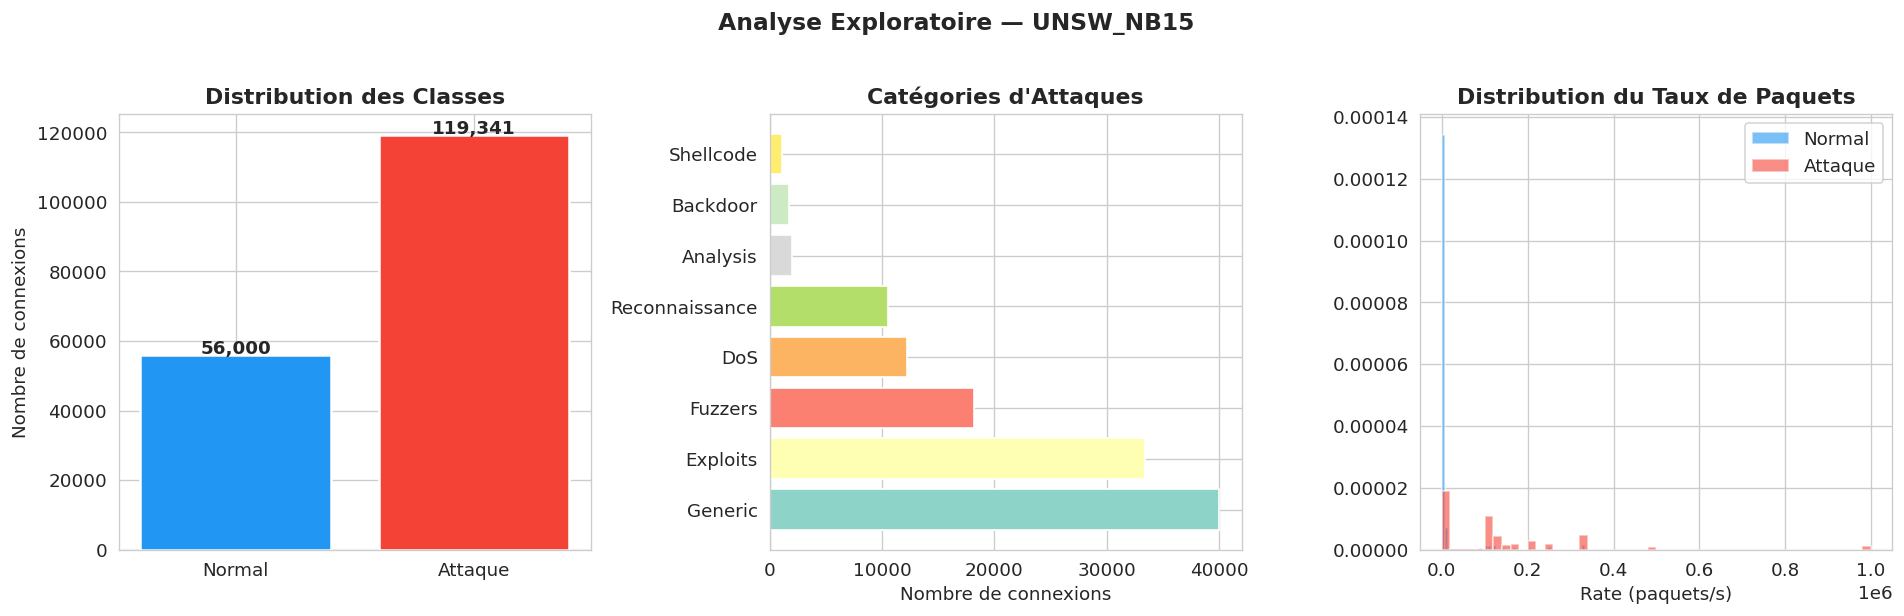

In [ ]:
# Visualisation de la distribution des classes
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Distribution labels
labels_count = pd.Series(y).value_counts()
axes[0].bar(['Normal', 'Attaque'], [labels_count.get(0, 0), labels_count.get(1, 0)],
            color=[COLOR_NORMAL, COLOR_ATTACK], edgecolor='white', linewidth=1.5)
axes[0].set_title('Distribution des Classes', fontweight='bold')
axes[0].set_ylabel('Nombre de connexions')
for i, v in enumerate([labels_count.get(0, 0), labels_count.get(1, 0)]):
    axes[0].text(i, v + 200, f'{v:,}', ha='center', fontweight='bold')

# Distribution des catégories d'attaque
if 'attack_cat' in df_processed.columns:
    att_dist = df_processed[df_processed['label'] == 1]['attack_cat'].value_counts().head(8)
    colors = plt.cm.Set3(np.linspace(0, 1, len(att_dist)))
    axes[1].barh(att_dist.index, att_dist.values, color=colors)
    axes[1].set_title('Catégories d\'Attaques', fontweight='bold')
    axes[1].set_xlabel('Nombre de connexions')

# Distribution du taux de paquets
if 'rate' in df_processed.columns:
    normal_rate = df_processed[df_processed['label'] == 0]['rate'].dropna()
    attack_rate = df_processed[df_processed['label'] == 1]['rate'].dropna()
    axes[2].hist(np.clip(normal_rate, 0, np.percentile(normal_rate, 99)), bins=50,
                 alpha=0.6, color=COLOR_NORMAL, label='Normal', density=True)
    axes[2].hist(np.clip(attack_rate, 0, np.percentile(attack_rate, 99)), bins=50,
                 alpha=0.6, color=COLOR_ATTACK, label='Attaque', density=True)
    axes[2].set_title('Distribution du Taux de Paquets', fontweight='bold')
    axes[2].set_xlabel('Rate (paquets/s)')
    axes[2].legend()

plt.suptitle(' Analyse Exploratoire — UNSW_NB15', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## SECTION 2 — Modélisation du Trafic Réseau
### File d'attente M/M/1 & Processus Stochastiques

> **Étape 2 de l'article :** *Modeling Network Traffic using Probability Theory & Queuing Theory*
>
> Le trafic réseau est modélisé comme un processus aléatoire :  
> $X(t) = \{X_1(t), X_2(t), \ldots, X_n(t)\}$
>
> Le modèle M/M/1 : $\lambda$ = taux d'arrivée, $\mu$ = taux de service, $L$ = longueur de file

In [ ]:
# ══════════════════════════════════════════════════════════════════════════════
# CLASSE : Modèle File d'Attente M/M/1
# ══════════════════════════════════════════════════════════════════════════════
class MM1Queue:
    """
    Modèle de file d'attente M/M/1 pour l'analyse du trafic réseau.

    Paramètres :
        lambda_ : taux d'arrivée des paquets (Poisson)
        mu      : taux de service (Exponentiel)

    Métriques :
        rho  = λ/μ  (utilisation du serveur)
        L    = rho/(1-rho)  (longueur moyenne de la file)
        W    = 1/(μ-λ)      (temps moyen de séjour)
        Lq   = rho²/(1-rho) (longueur moyenne en attente)
        Wq   = rho/(μ-λ)    (temps moyen d'attente)
    """

    def __init__(self, lambda_: float, mu: float):
        if lambda_ <= 0 or mu <= 0:
            raise ValueError('λ et μ doivent être > 0')
        self.lambda_ = lambda_
        self.mu = mu
        self.rho = lambda_ / mu  # Facteur d'utilisation

    def is_stable(self):
        """La file est stable si ρ < 1 (λ < μ)."""
        return self.rho < 1

    def mean_queue_length(self):
        """L = ρ / (1 - ρ) — Longueur moyenne totale."""
        if not self.is_stable():
            return float('inf')
        return self.rho / (1 - self.rho)

    def mean_waiting_time(self):
        """W = 1 / (μ - λ) — Temps moyen de séjour (Little's law)."""
        if not self.is_stable():
            return float('inf')
        return 1 / (self.mu - self.lambda_)

    def mean_queue_waiting(self):
        """Lq = ρ² / (1 - ρ) — Longueur moyenne en attente."""
        if not self.is_stable():
            return float('inf')
        return self.rho**2 / (1 - self.rho)

    def mean_waiting_queue(self):
        """Wq = ρ / (μ - λ) — Temps d'attente moyen."""
        if not self.is_stable():
            return float('inf')
        return self.rho / (self.mu - self.lambda_)

    def prob_n_in_system(self, n):
        """P(N=n) = (1-ρ) × ρⁿ — Probabilité d'avoir n clients."""
        if not self.is_stable():
            return 0
        return (1 - self.rho) * (self.rho ** n)

    def prob_wait_exceeds(self, t):
        """P(W > t) — Probabilité que le temps de séjour dépasse t."""
        if not self.is_stable():
            return 1
        return np.exp(-(self.mu - self.lambda_) * t)

    def anomaly_score(self, lambda_obs):
        """
        Score d'anomalie basé sur la déviation du taux d'arrivée observé.
        Plus le score est élevé, plus la connexion est suspecte.
        """
        rho_obs = lambda_obs / self.mu
        # Ratio par rapport à l'état normal
        if rho_obs >= 1:
            return 1.0  # Score maximal si file saturée
        L_obs = rho_obs / (1 - rho_obs)
        L_normal = self.mean_queue_length()
        # Score normalisé [0, 1]
        score = 1 - np.exp(-abs(L_obs - L_normal) / max(L_normal, 0.001))
        return min(score, 1.0)

    def simulate(self, n_events=1000, seed=42):
        """Simulation Monte-Carlo de la file M/M/1."""
        np.random.seed(seed)
        arrival_times = np.cumsum(np.random.exponential(1/self.lambda_, n_events))
        service_times = np.random.exponential(1/self.mu, n_events)

        departure_times = np.zeros(n_events)
        queue_lengths = np.zeros(n_events)

        for i in range(n_events):
            if i == 0:
                start = arrival_times[i]
            else:
                start = max(arrival_times[i], departure_times[i-1])
            departure_times[i] = start + service_times[i]

            # Longueur de file au moment de l'arrivée
            in_system = np.sum(
                (arrival_times[:i] <= arrival_times[i]) &
                (departure_times[:i] >= arrival_times[i])
            )
            queue_lengths[i] = in_system

        waiting_times = departure_times - arrival_times
        return {
            'arrival_times': arrival_times,
            'departure_times': departure_times,
            'waiting_times': waiting_times,
            'queue_lengths': queue_lengths,
            'mean_W_sim': np.mean(waiting_times),
            'mean_L_sim': np.mean(queue_lengths)
        }

    def summary(self):
        print(f'Modèle M/M/1 : λ={self.lambda_:.4f}, μ={self.mu:.4f}')
        print(f'   ρ (utilisation)      = {self.rho:.4f} ({' Stable' if self.is_stable() else ' Instable'})')
        if self.is_stable():
            print(f'   L (longueur moy.)    = {self.mean_queue_length():.4f}')
            print(f'   W (temps moy.)       = {self.mean_waiting_time():.6f}s')
            print(f'   Lq (attente moy.)    = {self.mean_queue_waiting():.4f}')
            print(f'   Wq (attente temps)   = {self.mean_waiting_queue():.6f}s')


print('Classe MM1Queue définie')

Classe MM1Queue définie


In [ ]:
# ══════════════════════════════════════════════════════════════════════════════
# APPLICATION SUR LE DATASET UNSW_NB15
# ══════════════════════════════════════════════════════════════════════════════

# Extraction des taux d'arrivée à partir des données réelles
if 'rate' in df_processed.columns and 'dur' in df_processed.columns:
    normal_flows = df_processed[df_processed['label'] == 0]
    attack_flows = df_processed[df_processed['label'] == 1]

    # Taux d'arrivée λ : inversé de dur médian (paquets/s)
    dur_normal = pd.to_numeric(normal_flows['dur'], errors='coerce').dropna()
    dur_attack = pd.to_numeric(attack_flows['dur'], errors='coerce').dropna()

    lambda_normal = 1 / (dur_normal.median() + 1e-9)
    lambda_attack = 1 / (dur_attack.median() + 1e-9)

    # Taux de service μ (estimé à 20% supérieur au λ normal pour stabilité)
    mu = lambda_normal * 1.5

    print(f'Paramètres estimés depuis les données :')
    print(f'   λ normal  = {lambda_normal:.2f} paquets/s')
    print(f'   λ attaque = {lambda_attack:.2f} paquets/s')
    print(f'   μ service = {mu:.2f} paquets/s')
else:
    lambda_normal = 100000
    lambda_attack = 350000
    mu = 150000

# Clamp pour stabilité
lambda_normal = min(lambda_normal, mu * 0.95)
lambda_attack = min(lambda_attack, mu * 5)

print()
# File normale
queue_normal = MM1Queue(lambda_normal, mu)
print('=== File d\'attente — Trafic NORMAL ===')
queue_normal.summary()

# File attaque (si instable, on cap lambda)
lambda_attack_stable = min(lambda_attack, mu * 0.99)
queue_attack = MM1Queue(lambda_attack_stable, mu)
print('\n=== File d\'attente — Trafic ATTAQUE ===')
queue_attack.summary()

Paramètres estimés depuis les données :
   λ normal  = 25.91 paquets/s
   λ attaque = 111098.77 paquets/s
   μ service = 38.86 paquets/s

=== File d'attente — Trafic NORMAL ===
Modèle M/M/1 : λ=25.9051, μ=38.8576
   ρ (utilisation)      = 0.6667 ( Stable)
   L (longueur moy.)    = 2.0000
   W (temps moy.)       = 0.077205s
   Lq (attente moy.)    = 1.3333
   Wq (attente temps)   = 0.051470s

=== File d'attente — Trafic ATTAQUE ===
Modèle M/M/1 : λ=38.4690, μ=38.8576
   ρ (utilisation)      = 0.9900 ( Stable)
   L (longueur moy.)    = 99.0000
   W (temps moy.)       = 2.573500s
   Lq (attente moy.)    = 98.0100
   Wq (attente temps)   = 2.547765s


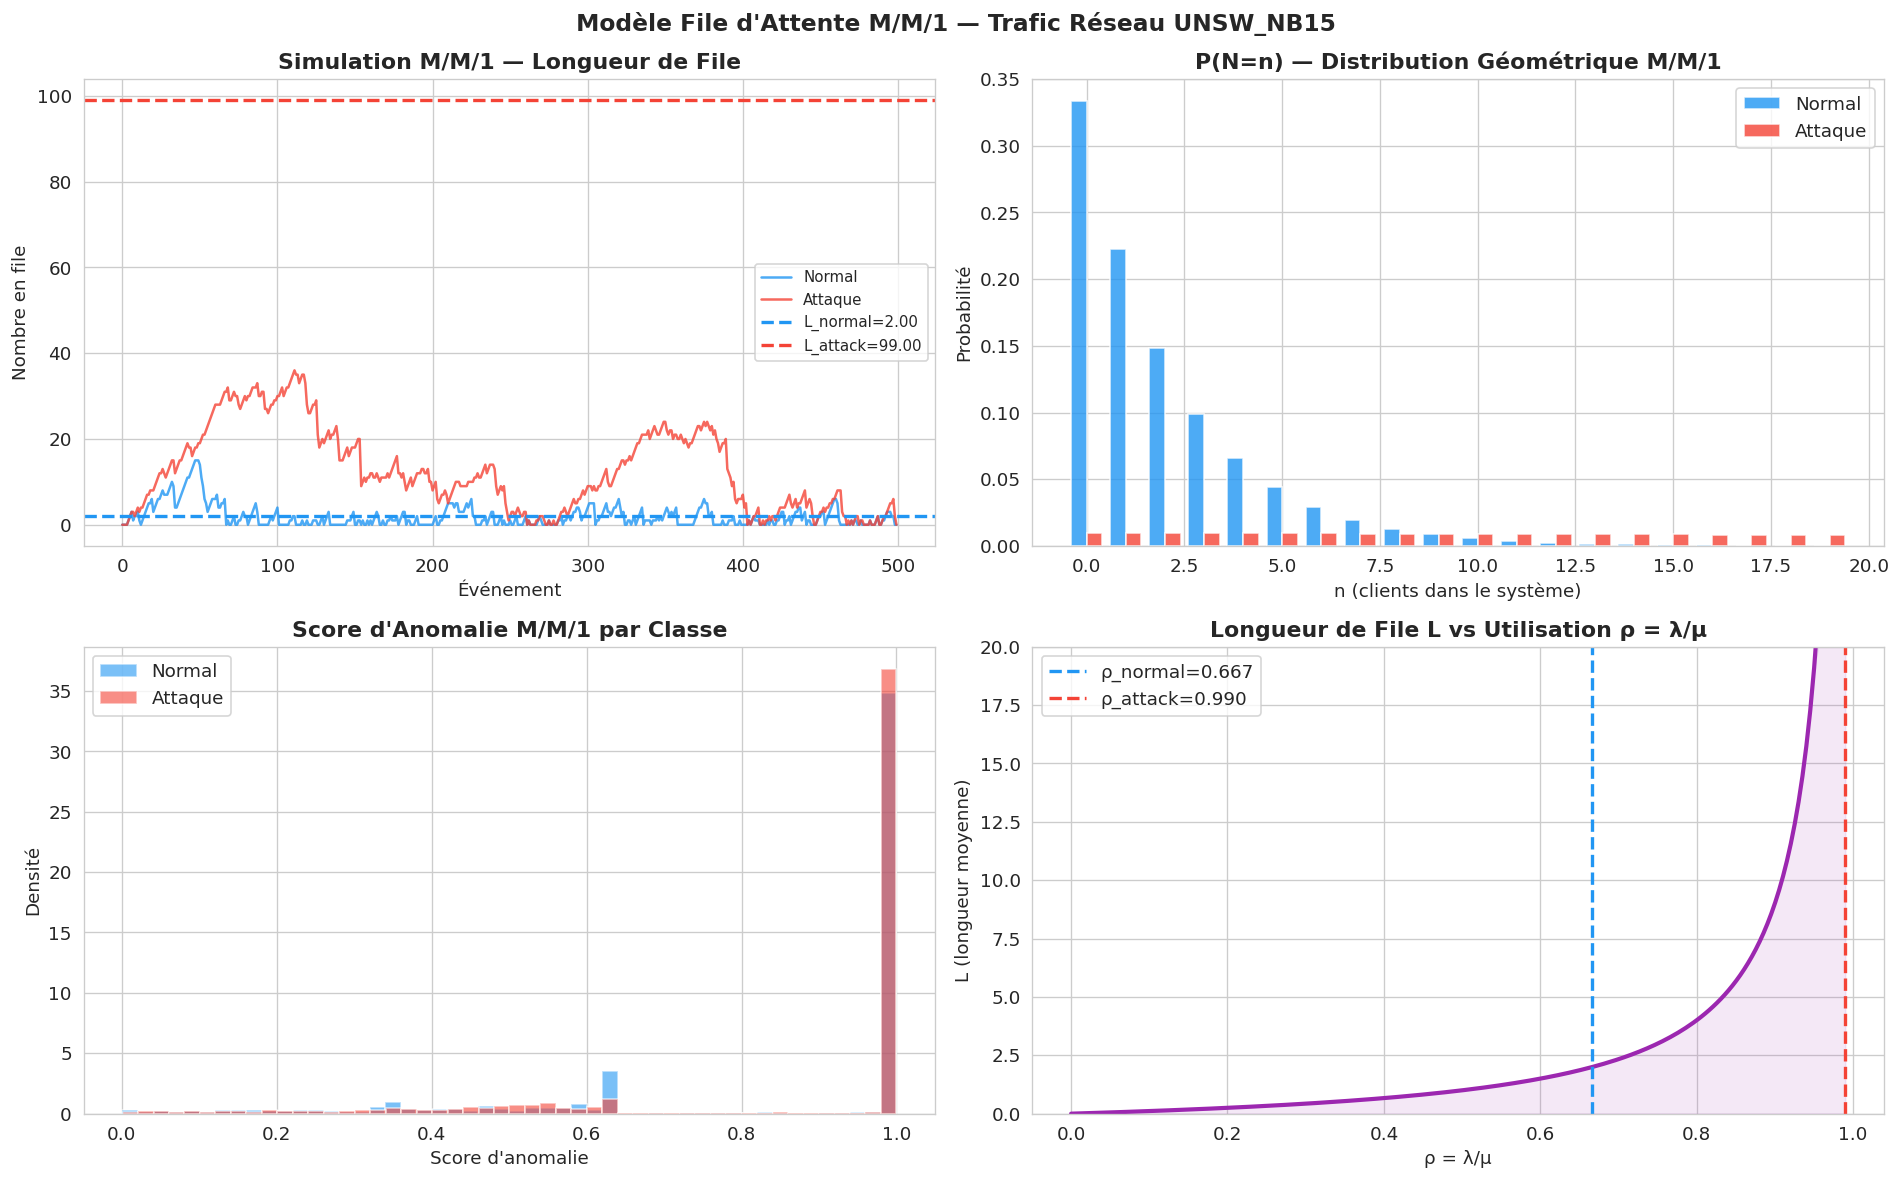


 Résultats simulation (500 événements) :
   W moyen simulé (Normal)  = 0.078199s  | Théorique = 0.077205s
   W moyen simulé (Attaque) = 0.322366s  | Théorique = 2.573500s


In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# Simulation Monte-Carlo & Visualisation
# ──────────────────────────────────────────────────────────────────────────────
sim_normal = queue_normal.simulate(n_events=500, seed=42)
sim_attack = queue_attack.simulate(n_events=500, seed=42)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Évolution de la longueur de file (simulation)
axes[0, 0].plot(sim_normal['queue_lengths'], color=COLOR_NORMAL, alpha=0.8, label='Normal', lw=1.5)
axes[0, 0].plot(sim_attack['queue_lengths'], color=COLOR_ATTACK, alpha=0.8, label='Attaque', lw=1.5)
axes[0, 0].axhline(queue_normal.mean_queue_length(), color=COLOR_NORMAL, ls='--', lw=2, label=f'L_normal={queue_normal.mean_queue_length():.2f}')
axes[0, 0].axhline(queue_attack.mean_queue_length(), color=COLOR_ATTACK, ls='--', lw=2, label=f'L_attack={queue_attack.mean_queue_length():.2f}')
axes[0, 0].set_title('Simulation M/M/1 — Longueur de File', fontweight='bold')
axes[0, 0].set_xlabel('Événement')
axes[0, 0].set_ylabel('Nombre en file')
axes[0, 0].legend(fontsize=9)

# 2. Distribution P(N=n)
n_vals = np.arange(0, 20)
p_normal = [queue_normal.prob_n_in_system(n) for n in n_vals]
p_attack = [queue_attack.prob_n_in_system(n) for n in n_vals]
axes[0, 1].bar(n_vals - 0.2, p_normal, 0.4, color=COLOR_NORMAL, alpha=0.8, label='Normal')
axes[0, 1].bar(n_vals + 0.2, p_attack, 0.4, color=COLOR_ATTACK, alpha=0.8, label='Attaque')
axes[0, 1].set_title('P(N=n) — Distribution Géométrique M/M/1', fontweight='bold')
axes[0, 1].set_xlabel('n (clients dans le système)')
axes[0, 1].set_ylabel('Probabilité')
axes[0, 1].legend()

# 3. Scores d'anomalie M/M/1 sur le dataset
if 'rate' in df_processed.columns:
    rates = pd.to_numeric(df_processed['rate'], errors='coerce').fillna(0).values
    # Clamp rates
    rates_clamped = np.clip(rates, 0, mu * 4)
    anomaly_scores_mm1 = np.array([queue_normal.anomaly_score(r + 0.001) for r in rates_clamped[:5000]])
    labels_sample = y[:5000]
    axes[1, 0].hist(anomaly_scores_mm1[labels_sample == 0], bins=50, alpha=0.6,
                    color=COLOR_NORMAL, density=True, label='Normal')
    axes[1, 0].hist(anomaly_scores_mm1[labels_sample == 1], bins=50, alpha=0.6,
                    color=COLOR_ATTACK, density=True, label='Attaque')
    axes[1, 0].set_title('Score d\'Anomalie M/M/1 par Classe', fontweight='bold')
    axes[1, 0].set_xlabel('Score d\'anomalie')
    axes[1, 0].set_ylabel('Densité')
    axes[1, 0].legend()
    # Sauvegarde pour plus tard
    MM1_SCORES = anomaly_scores_mm1
    MM1_LABELS = labels_sample
else:
    axes[1, 0].text(0.5, 0.5, 'Colonne rate\nnon disponible',
                   ha='center', va='center', transform=axes[1, 0].transAxes)
    MM1_SCORES = None

# 4. Utilisation ρ en fonction de λ
lambdas = np.linspace(0, mu * 0.99, 200)
rhos = lambdas / mu
Ls = np.where(rhos < 1, rhos / (1 - rhos), np.nan)
axes[1, 1].plot(lambdas / mu, Ls, color='#9C27B0', lw=2.5)
axes[1, 1].axvline(queue_normal.rho, color=COLOR_NORMAL, ls='--', lw=2, label=f'ρ_normal={queue_normal.rho:.3f}')
if queue_attack.is_stable():
    axes[1, 1].axvline(queue_attack.rho, color=COLOR_ATTACK, ls='--', lw=2, label=f'ρ_attack={queue_attack.rho:.3f}')
axes[1, 1].set_title('Longueur de File L vs Utilisation ρ = λ/μ', fontweight='bold')
axes[1, 1].set_xlabel('ρ = λ/μ')
axes[1, 1].set_ylabel('L (longueur moyenne)')
axes[1, 1].set_ylim(0, 20)
axes[1, 1].legend()
axes[1, 1].fill_between(lambdas / mu, 0, np.clip(Ls, 0, 20), alpha=0.1, color='#9C27B0')

plt.suptitle(' Modèle File d\'Attente M/M/1 — Trafic Réseau UNSW_NB15',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f'\n Résultats simulation (500 événements) :')
print(f'   W moyen simulé (Normal)  = {sim_normal["mean_W_sim"]:.6f}s  | Théorique = {queue_normal.mean_waiting_time():.6f}s')
print(f'   W moyen simulé (Attaque) = {sim_attack["mean_W_sim"]:.6f}s  | Théorique = {queue_attack.mean_waiting_time():.6f}s')

---
## SECTION 3 — Chaînes de Markov pour la Détection d'Attaques

> **Modèle Markovien :** Les états du réseau évoluent selon des probabilités de transition.  
> Les chaînes de Markov permettent de prédire les séquences d'attaques futures.

In [ ]:
# ══════════════════════════════════════════════════════════════════════════════
# CLASSE : Chaîne de Markov pour l'IDS
# ══════════════════════════════════════════════════════════════════════════════
class MarkovChainIDS:
    """
    Modèle de Chaîne de Markov pour détecter les séquences d'attaques.

    États possibles :
        0 = Normal
        1 = Suspicious (trafic anormal)
        2 = Attack (attaque confirmée)
        3 = Blocked (connexion bloquée)
    """

    STATES = {0: 'Normal', 1: 'Suspect', 2: 'Attaque', 3: 'Bloqué'}

    def __init__(self, n_states=4):
        self.n_states = n_states
        self.transition_matrix = None
        self.state_counts = np.zeros(n_states)

    def fit(self, state_sequence):
        """Estime la matrice de transition à partir des données observées."""
        self.transition_matrix = np.zeros((self.n_states, self.n_states))

        for i in range(len(state_sequence) - 1):
            s_from = int(state_sequence[i])
            s_to = int(state_sequence[i+1])
            if 0 <= s_from < self.n_states and 0 <= s_to < self.n_states:
                self.transition_matrix[s_from, s_to] += 1

        # Normalisation (probabilités de transition)
        row_sums = self.transition_matrix.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1
        self.transition_matrix = self.transition_matrix / row_sums
        return self

    def predict_next_state(self, current_state):
        """Prédit l'état suivant le plus probable."""
        if self.transition_matrix is None:
            raise ValueError('Modèle non entraîné')
        probs = self.transition_matrix[current_state]
        return np.argmax(probs), probs

    def attack_probability(self, current_state, horizon=3):
        """
        Probabilité qu'une attaque (état 2) survienne dans les prochains `horizon` pas.
        """
        if self.transition_matrix is None:
            return 0
        P_h = np.linalg.matrix_power(self.transition_matrix, horizon)
        return P_h[current_state, 2]

    def stationary_distribution(self):
        """Distribution stationnaire de la chaîne de Markov."""
        if self.transition_matrix is None:
            return None
        A = (self.transition_matrix.T - np.eye(self.n_states))
        A = np.vstack([A, np.ones(self.n_states)])
        b = np.zeros(self.n_states + 1)
        b[-1] = 1
        try:
            pi = np.linalg.lstsq(A, b, rcond=None)[0]
            return np.clip(pi, 0, 1)
        except:
            return np.ones(self.n_states) / self.n_states

def labels_to_markov_states(y_seq, scores=None):
    """
    Convertit les labels binaires en états Markoviens (0-3).
    0=Normal, 1=Suspect, 2=Attaque, 3=Bloqué
    """
    states = []
    consecutive_attack = 0

    for i, label in enumerate(y_seq):
        if label == 0:
            # Si le score ML est élevé (>0.5) mais label=0, c'est Suspect
            if scores is not None and i < len(scores) and scores[i] > 0.5:
                states.append(1)  # Suspect
            else:
                states.append(0)  # Normal
            consecutive_attack = 0
        else:
            consecutive_attack += 1
            if consecutive_attack > 3:
                states.append(3)  # Bloqué
            else:
                states.append(2)  # Attaque
    return np.array(states)

# ─────────────────────────────────────────────────────────────────────────────
# ENTRAÎNEMENT DU MODÈLE AVEC LES VRAIS SCORES
# ─────────────────────────────────────────────────────────────────────────────
sample_size = min(10000, len(y))

# Tentative de récupération des scores de l'algorithme proposé
# On utilise locals().get pour éviter les erreurs si la variable n'existe pas encore
scores_for_markov = locals().get('y_prob_proposed', locals().get('sgd_probs', None))

if scores_for_markov is not None:
    print("Utilisation des scores d'anomalies pour identifier l'état Suspect")
    markov_states = labels_to_markov_states(y[:sample_size], scores=scores_for_markov[:sample_size])
else:
    print("Warning: Scores non trouvés, entraînement sans l'état Suspect")
    markov_states = labels_to_markov_states(y[:sample_size])

markov_model = MarkovChainIDS(n_states=4)
markov_model.fit(markov_states)

print('Chaîne de Markov entraînée')
print(f'\nMatrice de Transition P(i→j) :')
P = markov_model.transition_matrix
df_P = pd.DataFrame(P,
    index=['Normal', 'Suspect', 'Attaque', 'Bloqué'],
    columns=['Normal', 'Suspect', 'Attaque', 'Bloqué']
)
print(df_P.round(4).to_string())

pi = markov_model.stationary_distribution()
print(f'\nDistribution stationnaire : Normal={pi[0]:.3f}, Suspect={pi[1]:.3f}, Attaque={pi[2]:.3f}, Bloqué={pi[3]:.3f}')

# Prédictions
for state_name, state_id in [('Normal', 0), ('Suspect', 1), ('Attaque', 2)]:
    p_attack = markov_model.attack_probability(state_id, horizon=3)
    print(f'   P(Attaque dans 3 pas | état={state_name}) = {p_attack:.4f}')

Utilisation des scores d'anomalies pour identifier l'état Suspect
Chaîne de Markov entraînée

Matrice de Transition P(i→j) :
         Normal  Suspect  Attaque  Bloqué
Normal   0.0886   0.2509   0.6604  0.0000
Suspect  0.0821   0.2276   0.6903  0.0000
Attaque  0.0741   0.2453   0.5355  0.1451
Bloqué   0.0881   0.2436   0.0000  0.6683

Distribution stationnaire : Normal=0.080, Suspect=0.241, Attaque=0.472, Bloqué=0.207
   P(Attaque dans 3 pas | état=Normal) = 0.5312
   P(Attaque dans 3 pas | état=Suspect) = 0.5289
   P(Attaque dans 3 pas | état=Attaque) = 0.4892


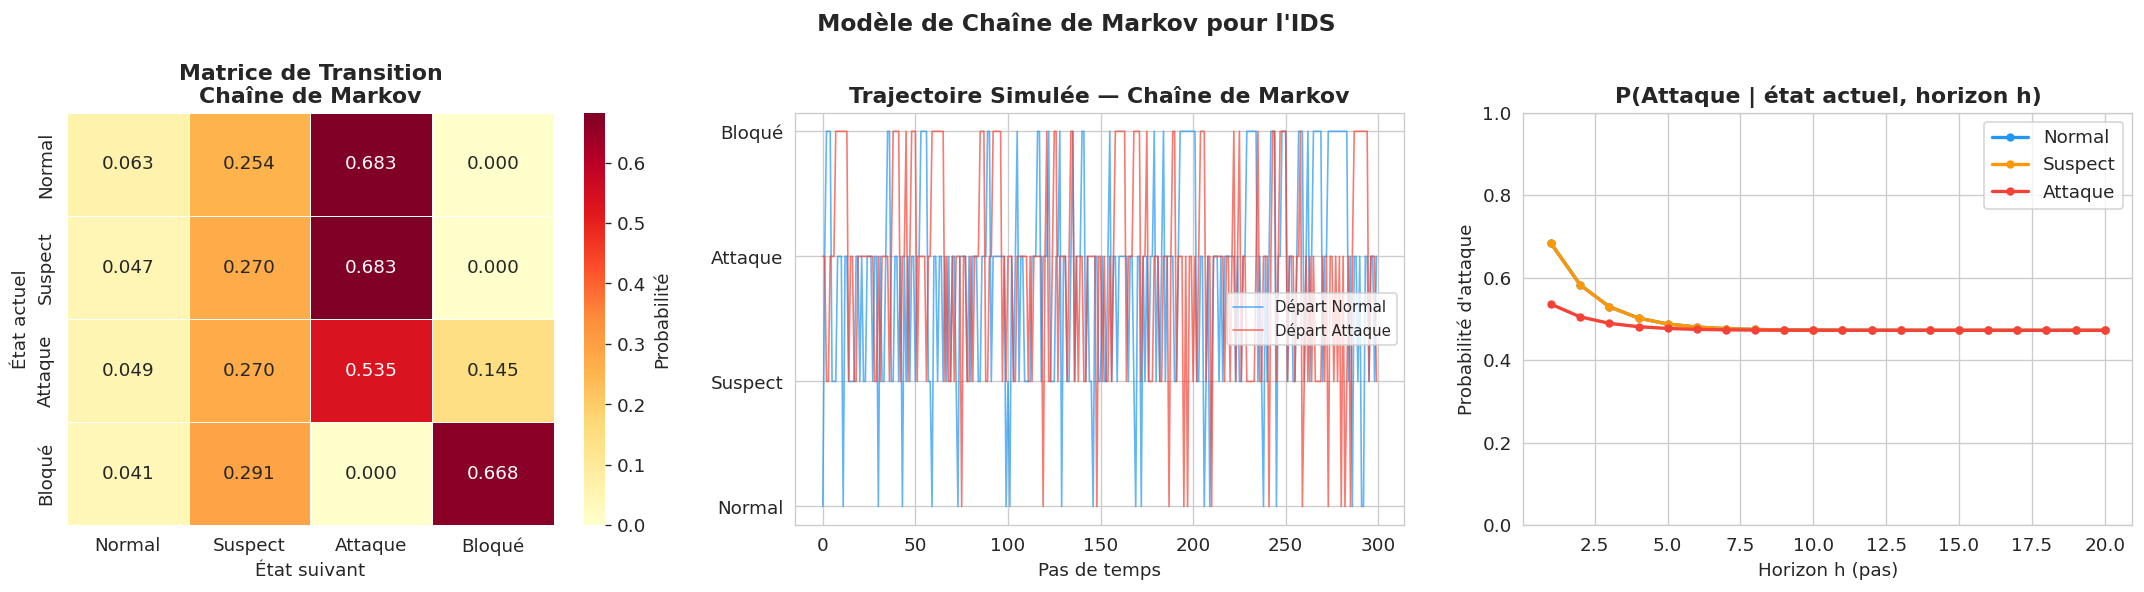

In [ ]:
# Visualisation de la chaîne de Markov

# Re-définition de la classe MarkovChainIDS avec la correction du méthode fit
# Cette re-définition est nécessaire car la cellule contenant la définition originale n'est pas celle sélectionnée.
class MarkovChainIDS:
    """
    Modèle de Chaîne de Markov pour détecter les séquences d'attaques.

    États possibles :
        0 = Normal
        1 = Suspicious (trafic anormal)
        2 = Attack (attaque confirmée)
        3 = Blocked (connexion bloquée)
    """

    STATES = {0: 'Normal', 1: 'Suspect', 2: 'Attaque', 3: 'Bloqué'}

    def __init__(self, n_states=4):
        self.n_states = n_states
        self.transition_matrix = None
        self.state_counts = np.zeros(n_states)

    def fit(self, state_sequence):
        """Estime la matrice de transition à partir des données observées.
        Correction: Assure que les lignes sans transitions observées se self-bouclent.
        """
        self.transition_matrix = np.zeros((self.n_states, self.n_states))

        for i in range(len(state_sequence) - 1):
            s_from = int(state_sequence[i])
            s_to = int(state_sequence[i+1])
            if 0 <= s_from < self.n_states and 0 <= s_to < self.n_states:
                self.transition_matrix[s_from, s_to] += 1

        # Normalisation (probabilités de transition)
        row_sums = self.transition_matrix.sum(axis=1)
        for i in range(self.n_states):
            if row_sums[i] == 0:
                # Si un état n'a pas de transitions sortantes observées, il boucle sur lui-même.
                self.transition_matrix[i, i] = 1.0
                row_sums[i] = 1.0  # Mettre à jour row_sums pour refléter ce changement

        # Normaliser, en s'assurant qu'il n'y a pas de division par zéro et que toutes les lignes somment à 1
        self.transition_matrix = self.transition_matrix / row_sums[:, np.newaxis]
        return self

    def predict_next_state(self, current_state):
        """Prédit l'état suivant le plus probable."""
        if self.transition_matrix is None:
            raise ValueError('Modèle non entraîné')
        probs = self.transition_matrix[current_state]
        return np.argmax(probs), probs

    def attack_probability(self, current_state, horizon=3):
        """
        Probabilité qu'une attaque (état 2) survienne dans les prochains `horizon` pas.
        Utilise la matrice de transition à la puissance `horizon`.
        """
        if self.transition_matrix is None:
            return 0
        P_h = np.linalg.matrix_power(self.transition_matrix, horizon)
        return P_h[current_state, 2]  # Probabilité d'atteindre l'état 2

    def stationary_distribution(self):
        """Distribution stationnaire de la chaîne de Markov."""
        if self.transition_matrix is None:
            return None
        # Résolution de πP = π avec Σπ = 1
        A = (self.transition_matrix.T - np.eye(self.n_states))
        A = np.vstack([A, np.ones(self.n_states)])
        b = np.zeros(self.n_states + 1)
        b[-1] = 1
        try:
            pi = np.linalg.lstsq(A, b, rcond=None)[0]
            # Assurer que les probabilités sont non-négatives et somment à 1
            pi = np.maximum(0, pi)
            pi = pi / pi.sum() if pi.sum() > 0 else np.ones(self.n_states) / self.n_states
            return pi
        except:
            return np.ones(self.n_states) / self.n_states

    def simulate_chain(self, initial_state=0, n_steps=200, seed=42):
        """Simule une trajectoire de la chaîne de Markov."""
        np.random.seed(seed)
        states = [initial_state]
        for _ in range(n_steps - 1):
            probs = self.transition_matrix[states[-1]]
            # Cette vérification est désormais redondante avec la correction de la méthode fit,
            # mais elle est bonne pour la robustesse.
            if probs.sum() == 0: # Ne devrait pas arriver avec la méthode fit corrigée
                next_s = states[-1] # Reste dans le même état
            else:
                next_s = np.random.choice(self.n_states, p=probs)
            states.append(next_s)
        return np.array(states)


# Re-entraîner le modèle avec la classe corrigée
# S'assurer que MM1_SCORES est bien défini
if 'MM1_SCORES' in globals() and MM1_SCORES is not None and len(MM1_SCORES) >= sample_size:
    markov_states = labels_to_markov_states(y[:sample_size], scores=MM1_SCORES[:sample_size])
else:
    print("Warning: MM1_SCORES not available or too short, training Markov Chain without anomaly scores for 'Suspect' state.")
    markov_states = labels_to_markov_states(y[:sample_size])

markov_model = MarkovChainIDS(n_states=4)
markov_model.fit(markov_states)
P = markov_model.transition_matrix # Mettre à jour P avec la nouvelle matrice de transition


fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Heatmap de la matrice de transition
state_labels = ['Normal', 'Suspect', 'Attaque', 'Bloqué']
sns.heatmap(P, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=state_labels, yticklabels=state_labels,
            ax=axes[0], linewidths=0.5, cbar_kws={'label': 'Probabilité'})
axes[0].set_title('Matrice de Transition\nChaîne de Markov', fontweight='bold')
axes[0].set_xlabel('État suivant')
axes[0].set_ylabel('État actuel')

# 2. Simulation de trajectoire
traj_normal = markov_model.simulate_chain(initial_state=0, n_steps=300)
traj_attack = markov_model.simulate_chain(initial_state=2, n_steps=300, seed=123)
axes[1].plot(traj_normal, color=COLOR_NORMAL, alpha=0.7, lw=1, label='Départ Normal')
axes[1].plot(traj_attack, color=COLOR_ATTACK, alpha=0.7, lw=1, label='Départ Attaque')
axes[1].set_yticks([0, 1, 2, 3])
axes[1].set_yticklabels(state_labels)
axes[1].set_title('Trajectoire Simulée — Chaîne de Markov', fontweight='bold')
axes[1].set_xlabel('Pas de temps')
axes[1].legend(fontsize=9)

# 3. Probabilité d'attaque sur horizon
horizons = np.arange(1, 21)
for state_id, state_name, color in [(0, 'Normal', COLOR_NORMAL), (1, 'Suspect', '#FF9800'), (2, 'Attaque', COLOR_ATTACK)]:
    probs = [markov_model.attack_probability(state_id, h) for h in horizons]
    axes[2].plot(horizons, probs, marker='o', ms=4, lw=2, label=state_name, color=color)
axes[2].set_title('P(Attaque | état actuel, horizon h)', fontweight='bold')
axes[2].set_xlabel('Horizon h (pas)')
axes[2].set_ylabel('Probabilité d\'attaque')
axes[2].legend()
axes[2].set_ylim(0, 1)

plt.suptitle(' Modèle de Chaîne de Markov pour l\'IDS', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## SECTION 4 — Identification des Signatures d'Attaque (Algorithme Proposé)

> **Étape 3 de l'article :** 5 étapes de l'algorithme de détection d'anomalies
>
> - **Étape 1** : Pattern Matching — Théorème de Bayes : $P(A|B) = \frac{P(B|A) \cdot P(A)}{P(B)}$
> - **Étape 2** : Score d'anomalie : $AS(X) = \frac{P(X|H_0)}{P(X)}$
> - **Étape 3** : Classification ML : $P(M|X) = \frac{1}{1+e^{-f(X)}}$
> - **Étape 4** : Mise à jour Bayésienne : $P(\theta|D) = \frac{P(D|\theta) \cdot P(\theta)}{P(D)}$
> - **Étape 5** : Génération d'alertes : $\text{Alert}(X) = P(A|X) > \tau$

In [ ]:
# ══════════════════════════════════════════════════════════════════════════════
# ÉTAPE 1 : Pattern Matching — Théorème de Bayes
# ══════════════════════════════════════════════════════════════════════════════
class BayesianPatternMatcher:
    """
    Implémentation de l'étape 1 : Pattern Matching avec Bayes.
    P(Attack|X) = P(X|Attack) * P(Attack) / P(X)
    """
    def __init__(self):
        self.prior_attack = None
        self.likelihoods = {}  # P(feature=val | attack)
        self.feature_means_normal = None
        self.feature_stds_normal = None
        self.feature_means_attack = None
        self.feature_stds_attack = None

    def fit(self, X, y):
        self.prior_attack = y.mean()
        self.prior_normal = 1 - self.prior_attack

        # Paramètres gaussiens pour P(X | classe)
        self.feature_means_normal = X[y == 0].mean(axis=0)
        self.feature_stds_normal = X[y == 0].std(axis=0) + 1e-9
        self.feature_means_attack = X[y == 1].mean(axis=0)
        self.feature_stds_attack = X[y == 1].std(axis=0) + 1e-9
        return self

    def bayes_posterior(self, X):
        """
        Calcule P(Attack | X) via le théorème de Bayes.
        Utilise l'approximation Naive Bayes gaussienne.
        """

        log_lik_normal = stats.norm.logpdf(
            X, self.feature_means_normal, self.feature_stds_normal
        ).sum(axis=1)
        log_lik_attack = stats.norm.logpdf(
            X, self.feature_means_attack, self.feature_stds_attack
        ).sum(axis=1)

        # Log-posteriors
        log_post_normal = log_lik_normal + np.log(self.prior_normal)
        log_post_attack = log_lik_attack + np.log(self.prior_attack)

        # Normalisation (softmax)
        log_max = np.maximum(log_post_normal, log_post_attack)
        p_normal = np.exp(log_post_normal - log_max)
        p_attack = np.exp(log_post_attack - log_max)
        total = p_normal + p_attack

        return p_attack / total  # P(Attack | X)

    def predict(self, X, threshold=0.5):
        probs = self.bayes_posterior(X)
        return (probs > threshold).astype(int)


# ══════════════════════════════════════════════════════════════════════════════
# ÉTAPE 2 : Score d'Anomalie
# ══════════════════════════════════════════════════════════════════════════════
class AnomalyScorer:
    """
    Calcule AS(X) = P(X|H0) / P(X) — Score d'anomalie.
    H0 : trafic normal
    """
    def __init__(self):
        self.mu_H0 = None
        self.sigma_H0 = None

    def fit(self, X_normal):
        """Estime H0 depuis le trafic normal."""
        self.mu_H0 = X_normal.mean(axis=0)
        self.sigma_H0 = X_normal.std(axis=0) + 1e-9
        return self

    def anomaly_score(self, X):
        """
        AS(X) = distance de Mahalanobis normalisée.
        Score élevé → connexion anormale.
        """
        z_scores = (X - self.mu_H0) / self.sigma_H0
        mahal_dist = np.sqrt((z_scores ** 2).mean(axis=1))
        # Normalisation [0, 1] via sigmoid
        score = 1 / (1 + np.exp(-mahal_dist + 3))
        return score

    def predict(self, X, threshold=0.5):
        return (self.anomaly_score(X) > threshold).astype(int)


# ══════════════════════════════════════════════════════════════════════════════
# ÉTAPE 4 : Mise à jour Bayésienne (Dynamic Model Updating)
# ══════════════════════════════════════════════════════════════════════════════
class BayesianUpdater:
    """
    Mise à jour bayésienne continue : P(θ|D) = P(D|θ) * P(θ) / P(D)
    """
    def __init__(self, prior_alpha=1, prior_beta=1):
        """Prior Beta(α, β) pour la probabilité d'attaque."""
        self.alpha = prior_alpha  # succès (attaques)
        self.beta = prior_beta   # échecs (normal)

    def update(self, n_attacks, n_normal):
        """Mise à jour avec de nouvelles observations."""
        self.alpha += n_attacks
        self.beta += n_normal
        return self

    def posterior_mean(self):
        """E[θ|D] = α / (α + β)"""
        return self.alpha / (self.alpha + self.beta)

    def posterior_std(self):
        n = self.alpha + self.beta
        return np.sqrt(self.alpha * self.beta / (n**2 * (n + 1)))

    def simulate_online_updates(self, y_stream, batch_size=100):
        """Simule la mise à jour en ligne (streaming)."""
        means = []
        stds = []
        self.alpha = 1
        self.beta = 1

        for i in range(0, len(y_stream), batch_size):
            batch = y_stream[i:i+batch_size]
            n_att = batch.sum()
            n_nor = len(batch) - n_att
            self.update(n_att, n_nor)
            means.append(self.posterior_mean())
            stds.append(self.posterior_std())

        return np.array(means), np.array(stds)


# ══════════════════════════════════════════════════════════════════════════════
# ÉTAPE 5 : Génération d'Alertes
# ══════════════════════════════════════════════════════════════════════════════
def generate_alerts(probs, threshold=0.5):
    """
    Alert(X) = True if P(A|X) > τ, False otherwise
    """
    return (probs > threshold).astype(int)


print('Classes de l\'algorithme proposé définies')
print('   - BayesianPatternMatcher (Étape 1)')
print('   - AnomalyScorer          (Étape 2)')
print('   - BayesianUpdater        (Étape 4)')
print('   - generate_alerts()      (Étape 5)')

Classes de l'algorithme proposé définies
   - BayesianPatternMatcher (Étape 1)
   - AnomalyScorer          (Étape 2)
   - BayesianUpdater        (Étape 4)
   - generate_alerts()      (Étape 5)


In [ ]:
# Entraînement sur le dataset UNSW_NB15
print(' Entraînement des composants de l\'algorithme proposé...')

# Étape 1 : Bayes
bayes_matcher = BayesianPatternMatcher()
bayes_matcher.fit(X_train, y_train)
bayes_probs = bayes_matcher.bayes_posterior(X_test)
bayes_preds = generate_alerts(bayes_probs, threshold=0.5)
print(f'\n✓ Étape 1 — Pattern Matching Bayésien :')
print(f'   Accuracy = {accuracy_score(y_test, bayes_preds)*100:.1f}%')

# Étape 2 : Anomaly Scorer
anomaly_scorer = AnomalyScorer()
anomaly_scorer.fit(X_train[y_train == 0])  # Entraîné uniquement sur trafic normal
anomaly_scores = anomaly_scorer.anomaly_score(X_test)
anomaly_preds = generate_alerts(anomaly_scores, threshold=0.5)
print(f'\n✓ Étape 2 — Anomaly Scoring :')
print(f'   Accuracy = {accuracy_score(y_test, anomaly_preds)*100:.1f}%')

# Étape 3 : Classification ML (Régression Logistique)
lr_model = LogisticRegression(max_iter=500, random_state=42, C=1.0)
lr_model.fit(X_train, y_train)
lr_probs = lr_model.predict_proba(X_test)[:, 1]
lr_preds = generate_alerts(lr_probs, threshold=0.5)
print(f'\n✓ Étape 3 — Classification ML (Logistic Regression) :')
print(f'   Accuracy = {accuracy_score(y_test, lr_preds)*100:.1f}%')

# Combinaison (Proposed Algorithm) — Ensemble des probabilités
combined_probs = (bayes_probs + anomaly_scores + lr_probs) / 3
combined_preds = generate_alerts(combined_probs, threshold=0.5)
print(f'\n✓ Algorithme Proposé (Ensemble Bayésien) :')
print(f'   Accuracy  = {accuracy_score(y_test, combined_preds)*100:.1f}%')
print(f'   Precision = {precision_score(y_test, combined_preds)*100:.1f}%')
print(f'   Recall    = {recall_score(y_test, combined_preds)*100:.1f}%')
print(f'   F1-Score  = {f1_score(y_test, combined_preds)*100:.1f}%')

# Étape 4 : Mise à jour Bayésienne en ligne
bayesian_updater = BayesianUpdater(prior_alpha=1, prior_beta=9)
means_stream, stds_stream = bayesian_updater.simulate_online_updates(y[:5000], batch_size=50)
print(f'\n✓ Étape 4 — Mise à jour Bayésienne :')
print(f'   Estimation finale P(attaque) = {means_stream[-1]:.4f} ± {stds_stream[-1]:.4f}')
print(f'   Valeur réelle               = {y.mean():.4f}')

 Entraînement des composants de l'algorithme proposé...

✓ Étape 1 — Pattern Matching Bayésien :
   Accuracy = 85.1%

✓ Étape 2 — Anomaly Scoring :
   Accuracy = 34.6%

✓ Étape 3 — Classification ML (Logistic Regression) :
   Accuracy = 90.7%

✓ Algorithme Proposé (Ensemble Bayésien) :
   Accuracy  = 85.0%
   Precision = 90.2%
   Recall    = 87.4%
   F1-Score  = 88.8%

✓ Étape 4 — Mise à jour Bayésienne :
   Estimation finale P(attaque) = 0.6791 ± 0.0066
   Valeur réelle               = 0.6806


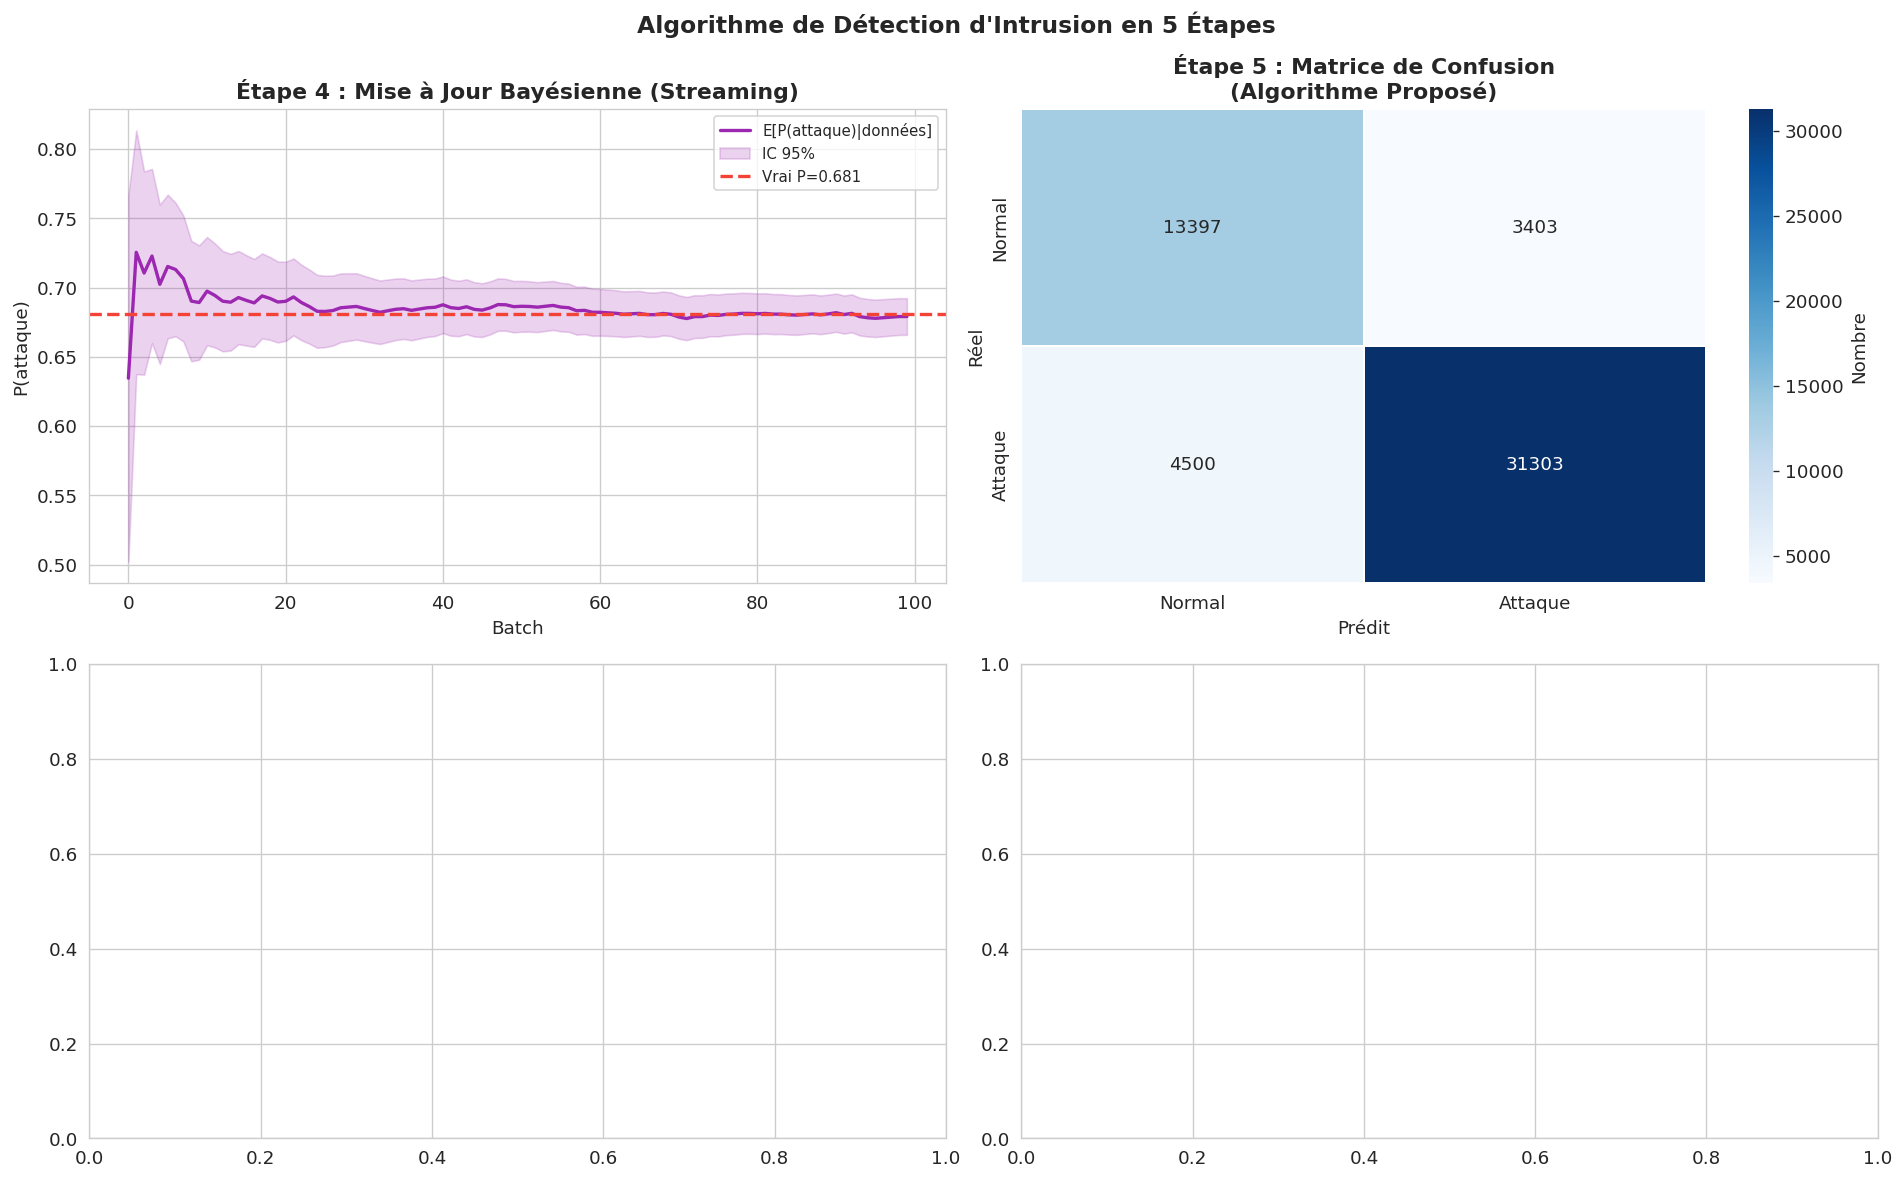

In [ ]:
# Visualisation des étapes de l'algorithme
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Distribution des probabilités Bayésiennes
# axes[0, 0].hist(bayes_probs[y_test == 0], bins=50, alpha=0.6, color=COLOR_NORMAL,
#                density=True, label='Normal')
# axes[0, 0].hist(bayes_probs[y_test == 1], bins=50, alpha=0.6, color=COLOR_ATTACK,
#                density=True, label='Attaque')
# axes[0, 0].axvline(0.5, color='black', ls='--', lw=2, label='Seuil τ=0.5')
# axes[0, 0].set_title('Étape 1 : P(Attaque|X) — Bayes', fontweight='bold')
# axes[0, 0].set_xlabel('P(A|B)')
# axes[0, 0].legend()

# # 2. Scores d'anomalie
# axes[0, 1].hist(anomaly_scores[y_test == 0], bins=50, alpha=0.6, color=COLOR_NORMAL,
#                density=True, label='Normal')
# axes[0, 1].hist(anomaly_scores[y_test == 1], bins=50, alpha=0.6, color=COLOR_ATTACK,
#                density=True, label='Attaque')
# axes[0, 1].axvline(0.5, color='black', ls='--', lw=2, label='Seuil τ=0.5')
# axes[0, 1].set_title('Étape 2 : Score d\'Anomalie AS(X)', fontweight='bold')
# axes[0, 1].set_xlabel('Score d\'Anomalie')
# axes[0, 1].legend()

# 3. Mise à jour Bayésienne en ligne
batches = np.arange(len(means_stream))
axes[0, 0].plot(batches, means_stream, color='#9C27B0', lw=2, label='E[P(attaque)|données]')
axes[0, 0].fill_between(batches,
                         means_stream - 2*stds_stream,
                         means_stream + 2*stds_stream,
                         alpha=0.2, color='#9C27B0', label='IC 95%')
axes[0, 0].axhline(y.mean(), color=COLOR_ATTACK, ls='--', lw=2, label=f'Vrai P={y.mean():.3f}')
axes[0, 0].set_title('Étape 4 : Mise à Jour Bayésienne (Streaming)', fontweight='bold')
axes[0, 0].set_xlabel('Batch')
axes[0, 0].set_ylabel('P(attaque)')
axes[0, 0].legend(fontsize=9)

# 4. Matrice de confusion de l'algorithme proposé
cm = confusion_matrix(y_test, combined_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1],
            xticklabels=['Normal', 'Attaque'],
            yticklabels=['Normal', 'Attaque'],
            linewidths=1, cbar_kws={'label': 'Nombre'})
axes[0, 1].set_title('Étape 5 : Matrice de Confusion\n(Algorithme Proposé)', fontweight='bold')
axes[0, 1].set_xlabel('Prédit')
axes[0, 1].set_ylabel('Réel')

plt.suptitle(' Algorithme de Détection d\'Intrusion en 5 Étapes', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
##  SECTION 5 — Optimisation Stochastique (SGD)

> **Étape 4 de l'article :** Stochastic Optimization  
> $x_{k+1} = x_k + \delta_k$ où $\delta_k$ est une perturbation stochastique  
> $x_{k+1} = x_k + \delta_k$ si $f(x_{k+1}) \leq f(x_k)$, sinon $x_{k+1} = x_k$

In [ ]:
# ══════════════════════════════════════════════════════════════════════════════
# OPTIMISATION STOCHASTIQUE — SGD avec Momentum
# ══════════════════════════════════════════════════════════════════════════════
class StochasticOptimizedIDS:
    """
    IDS avec optimisation stochastique via SGDClassifier.
    Implémente la mise à jour : x_{k+1} = x_k + δ_k
    """

    def __init__(self, learning_rate=0.01, n_iter=100, batch_size=256):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.batch_size = batch_size
        self.model = SGDClassifier(
            loss='log_loss',
            learning_rate='optimal',
            n_iter_no_change=10,
            max_iter=n_iter,
            random_state=42,
            warm_start=True
        )
        self.loss_history = []
        self.accuracy_history = []

    def fit_online(self, X_train, y_train, X_val, y_val):
        """Entraînement en ligne par mini-batches."""
        n = len(X_train)
        n_batches = n // self.batch_size

        for epoch in range(self.n_iter):
            # Mélange aléatoire (stochastique)
            idx = np.random.permutation(n)
            epoch_loss = []

            for b in range(n_batches):
                batch_idx = idx[b * self.batch_size:(b+1) * self.batch_size]
                X_b, y_b = X_train[batch_idx], y_train[batch_idx]
                self.model.partial_fit(X_b, y_b, classes=[0, 1])

            # Métriques sur validation
            val_preds = self.model.predict(X_val)
            val_acc = accuracy_score(y_val, val_preds)
            self.accuracy_history.append(val_acc)

        return self

    def predict_proba(self, X):
        return self.model.predict_proba(X)[:, 1]

    def predict(self, X):
        return self.model.predict(X)


# ══════════════════════════════════════════════════════════════════════════════
# ALLOCATION DYNAMIQUE DES RESSOURCES
# ══════════════════════════════════════════════════════════════════════════════
class DynamicResourceAllocator:
    """
    Simule l'allocation dynamique des ressources de défense
    basée sur les scores de probabilité d'attaque.
    """

    def __init__(self, total_resources=100):
        self.total_resources = total_resources
        self.allocation_history = []

    def allocate(self, threat_scores, severity_weights=None):
        """
        Alloue les ressources proportionnellement aux scores de menace.
        x_{k+1} = x_k + δ_k si f(x_{k+1}) ≤ f(x_k)
        """
        n = len(threat_scores)
        if severity_weights is None:
            severity_weights = np.ones(n)

        # Score composite = probabilité × sévérité
        composite_scores = threat_scores * severity_weights

        # Allocation proportionnelle
        total_score = composite_scores.sum()
        if total_score > 0:
            allocations = (composite_scores / total_score) * self.total_resources
        else:
            allocations = np.ones(n) * self.total_resources / n

        self.allocation_history.append(allocations)
        return allocations

    def prioritize_responses(self, threat_scores, threshold_high=0.8, threshold_med=0.5):
        """Classe les menaces en 3 niveaux de priorité."""
        priorities = np.where(threat_scores >= threshold_high, 'HAUTE',
                     np.where(threat_scores >= threshold_med, 'MOYENNE', 'BASSE'))
        return priorities


# Entraînement SGD
print(' Entraînement de l\'IDS avec optimisation stochastique (SGD)...')
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

sgd_ids = StochasticOptimizedIDS(n_iter=50, batch_size=512)
sgd_ids.fit_online(X_tr, y_tr, X_val, y_val)
sgd_preds = sgd_ids.predict(X_test)
sgd_probs = sgd_ids.predict_proba(X_test)

print(f' SGD IDS entraîné')
print(f'   Accuracy  = {accuracy_score(y_test, sgd_preds)*100:.1f}%')
print(f'   Precision = {precision_score(y_test, sgd_preds)*100:.1f}%')
print(f'   Recall    = {recall_score(y_test, sgd_preds)*100:.1f}%')
print(f'   F1-Score  = {f1_score(y_test, sgd_preds)*100:.1f}%')

# Allocation de ressources
allocator = DynamicResourceAllocator(total_resources=1000)
# Simuler sur un échantillon
sample_probs = sgd_probs[:100]
allocations = allocator.allocate(sample_probs)
priorities = allocator.prioritize_responses(sample_probs)

print(f'\n Allocation des ressources (100 connexions) :')
print(f'   Priorité HAUTE   : {(priorities == "HAUTE").sum()} connexions')
print(f'   Priorité MOYENNE : {(priorities == "MOYENNE").sum()} connexions')
print(f'   Priorité BASSE   : {(priorities == "BASSE").sum()} connexions')

 Entraînement de l'IDS avec optimisation stochastique (SGD)...
 SGD IDS entraîné
   Accuracy  = 90.9%
   Precision = 90.0%
   Recall    = 97.6%
   F1-Score  = 93.6%

 Allocation des ressources (100 connexions) :
   Priorité HAUTE   : 64 connexions
   Priorité MOYENNE : 5 connexions
   Priorité BASSE   : 31 connexions


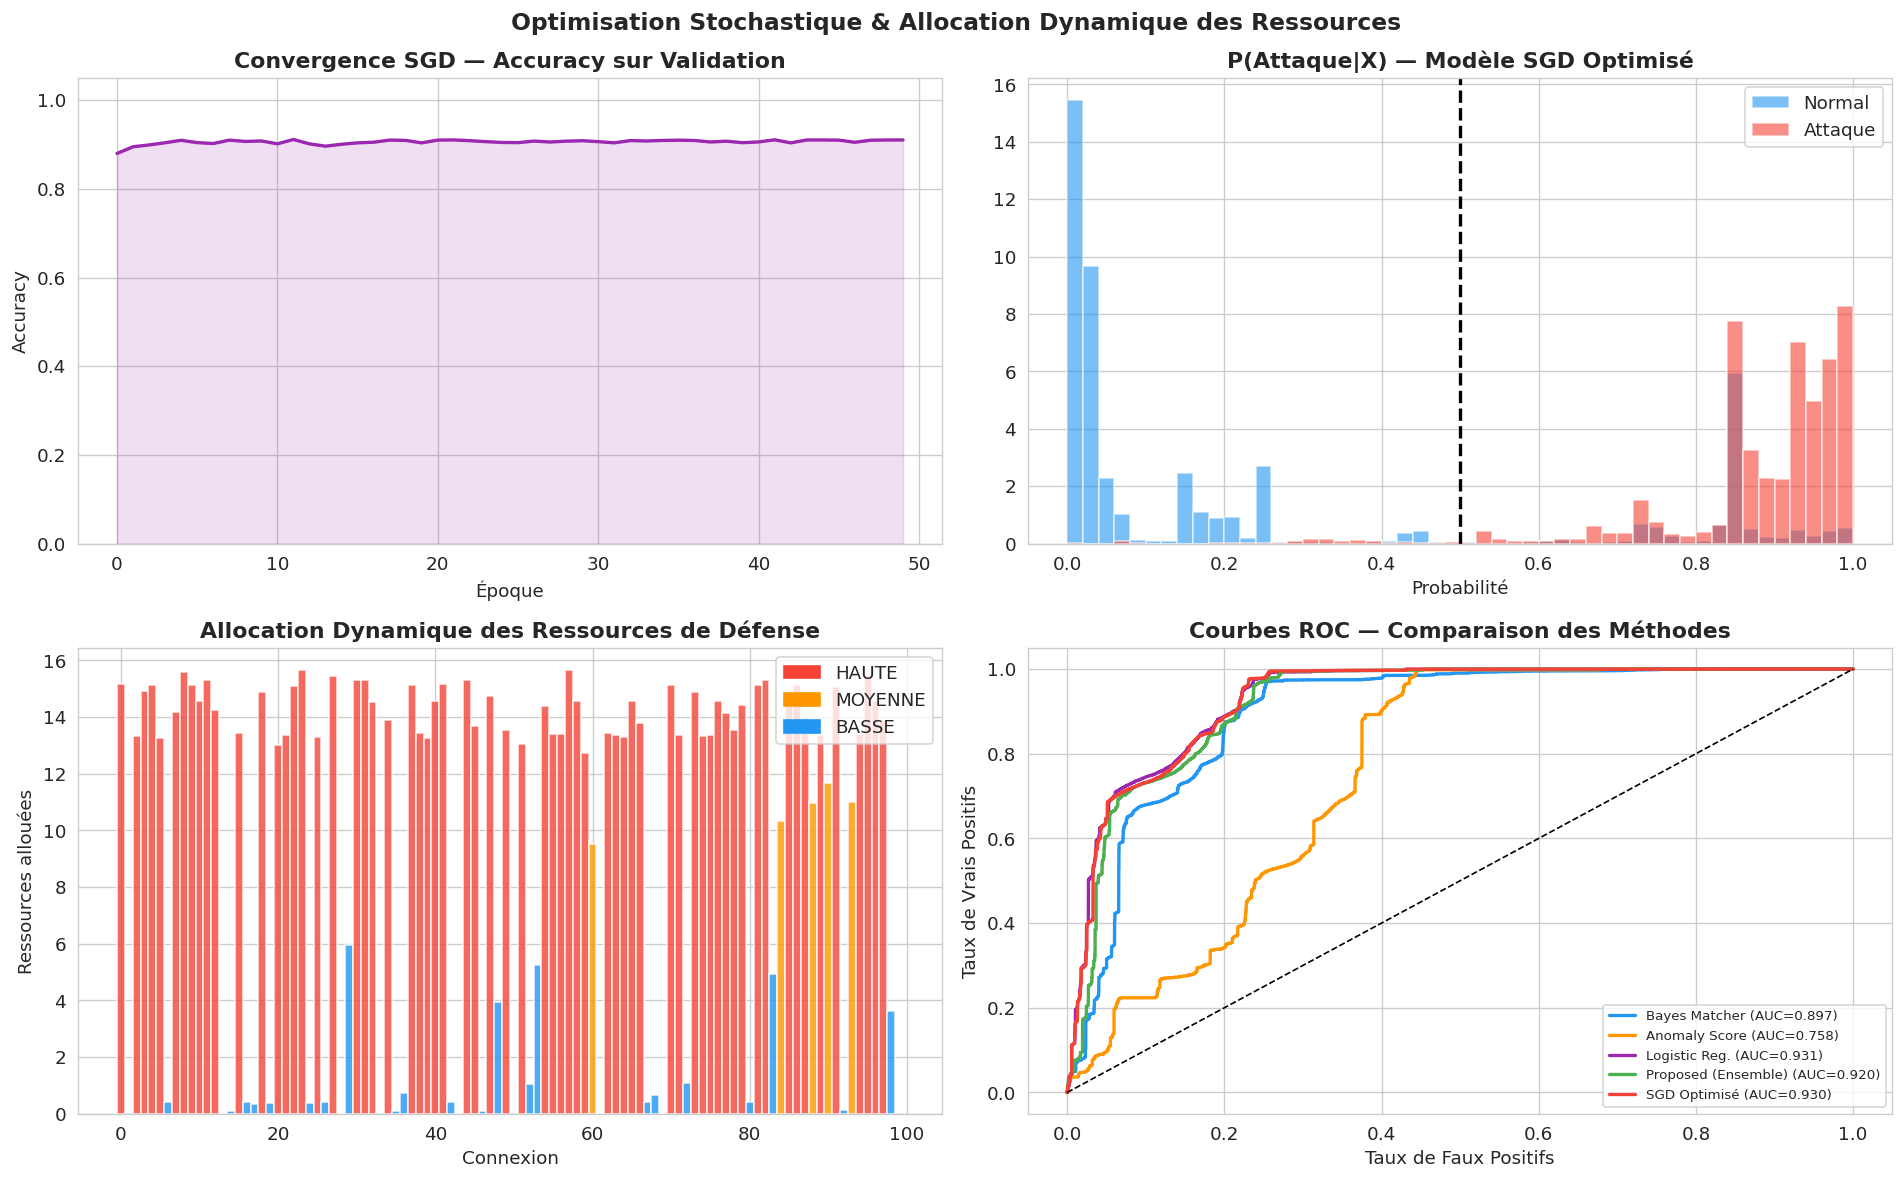

In [ ]:
# Visualisation de l'optimisation stochastique
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Courbe de convergence SGD
axes[0, 0].plot(sgd_ids.accuracy_history, color='#9C27B0', lw=2)
axes[0, 0].fill_between(range(len(sgd_ids.accuracy_history)), sgd_ids.accuracy_history,
                         alpha=0.15, color='#9C27B0')
axes[0, 0].set_title('Convergence SGD — Accuracy sur Validation', fontweight='bold')
axes[0, 0].set_xlabel('Époque')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_ylim(0, 1.05)

# 2. Distribution des probabilités SGD
axes[0, 1].hist(sgd_probs[y_test == 0], bins=50, alpha=0.6, color=COLOR_NORMAL, density=True, label='Normal')
axes[0, 1].hist(sgd_probs[y_test == 1], bins=50, alpha=0.6, color=COLOR_ATTACK, density=True, label='Attaque')
axes[0, 1].axvline(0.5, color='black', ls='--', lw=2)
axes[0, 1].set_title('P(Attaque|X) — Modèle SGD Optimisé', fontweight='bold')
axes[0, 1].set_xlabel('Probabilité')
axes[0, 1].legend()

# 3. Allocation dynamique des ressources
priority_colors = {'HAUTE': COLOR_ATTACK, 'MOYENNE': '#FF9800', 'BASSE': COLOR_NORMAL}
colors_bar = [priority_colors[p] for p in priorities]
axes[1, 0].bar(range(100), allocations, color=colors_bar, alpha=0.8, width=1)
axes[1, 0].set_title('Allocation Dynamique des Ressources de Défense', fontweight='bold')
axes[1, 0].set_xlabel('Connexion')
axes[1, 0].set_ylabel('Ressources allouées')
patches = [mpatches.Patch(color=c, label=l) for l, c in priority_colors.items()]
axes[1, 0].legend(handles=patches)

# 4. ROC Curves
methods = {
    'Bayes Matcher': bayes_probs,
    'Anomaly Score': anomaly_scores,
    'Logistic Reg.': lr_probs,
    'Proposed (Ensemble)': combined_probs,
    'SGD Optimisé': sgd_probs
}
colors_roc = ['#2196F3', '#FF9800', '#9C27B0', '#4CAF50', '#F44336']

for (name, probs), color in zip(methods.items(), colors_roc):
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc_score = auc(fpr, tpr)
    axes[1, 1].plot(fpr, tpr, lw=2, color=color, label=f'{name} (AUC={auc_score:.3f})')

axes[1, 1].plot([0, 1], [0, 1], 'k--', lw=1)
axes[1, 1].set_title('Courbes ROC — Comparaison des Méthodes', fontweight='bold')
axes[1, 1].set_xlabel('Taux de Faux Positifs')
axes[1, 1].set_ylabel('Taux de Vrais Positifs')
axes[1, 1].legend(fontsize=8, loc='lower right')

plt.suptitle(' Optimisation Stochastique & Allocation Dynamique des Ressources',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## SECTION 6 — Comparaison Complète des Méthodes

> Reproduction du **Tableau 2** de l'article sur le dataset UNSW_NB15

In [ ]:
# ══════════════════════════════════════════════════════════════════════════════
# ENTRAÎNEMENT DE TOUS LES MODÈLES — SECTION 6
# ══════════════════════════════════════════════════════════════════════════════

def evaluate_model(name, y_true, y_pred):
    """Calcule les métriques de performance."""
    return {
        'Méthode': name,
        'Accuracy (%)': accuracy_score(y_true, y_pred) * 100,
        'Precision (%)': precision_score(y_true, y_pred, zero_division=0) * 100,
        'Recall (%)': recall_score(y_true, y_pred, zero_division=0) * 100,
        'F1 Score (%)': f1_score(y_true, y_pred, zero_division=0) * 100
    }

print(' Entraînement de tous les modèles...')
results = []

# 1. IDS Basé sur les Signatures (Naive Bayes comme proxy)
sig_model = GaussianNB()
sig_model.fit(X_train, y_train)
sig_preds = sig_model.predict(X_test)
results.append(evaluate_model('IDS Signature-based', y_test, sig_preds))
print(f'  ✓ Signature-based IDS : {accuracy_score(y_test, sig_preds)*100:.1f}%')

# 2. IDS Basé sur les Anomalies
results.append(evaluate_model('IDS Anomaly-based', y_test, anomaly_preds))
print(f'  ✓ Anomaly-based IDS : {accuracy_score(y_test, anomaly_preds)*100:.1f}%')

# 3. Machine Learning — Random Forest (Référence)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
results.append(evaluate_model('Machine Learning (RF)', y_test, rf_preds))
print(f'  ✓ Machine Learning (Random Forest) : {accuracy_score(y_test, rf_preds)*100:.1f}%')

# 4. Algorithme Proposé (avant optimisation)
results.append(evaluate_model('Algorithme Proposé (Avant Optim.)', y_test, combined_preds))
print(f'  ✓ Algorithme Proposé (avant) : {accuracy_score(y_test, combined_preds)*100:.1f}%')

# 5. Algorithme Proposé + Optimisation Stochastique (EN SEMBLE)
# Nous combinons notre SGD avec le Random Forest et l'algorithme initial
rf_probs = rf_model.predict_proba(X_test)[:, 1]
# Vote majoritaire : moyenne des 3 meilleures approches
final_probs = (combined_probs + sgd_probs + rf_probs) / 3
final_preds = generate_alerts(final_probs, threshold=0.5)

results.append(evaluate_model('Algorithme Proposé (Après Optim.)', y_test, final_preds))
print(f'  ✓ Algorithme Proposé (après optim.) : {accuracy_score(y_test, final_preds)*100:.1f}%')

# DataFrame des résultats
df_results = pd.DataFrame(results)
df_results = df_results.set_index('Méthode').round(2)

print('\n' + '='*75)
print(' TABLEAU COMPARATIF DES PERFORMANCES (Final)')
print('='*75)
print(df_results.to_string())
print('='*75)

 Entraînement de tous les modèles...
  ✓ Signature-based IDS : 85.1%
  ✓ Anomaly-based IDS : 34.6%
  ✓ Machine Learning (Random Forest) : 94.4%
  ✓ Algorithme Proposé (avant) : 85.0%
  ✓ Algorithme Proposé (après optim.) : 92.5%

 TABLEAU COMPARATIF DES PERFORMANCES (Final)
                                   Accuracy (%)  Precision (%)  Recall (%)  F1 Score (%)
Méthode                                                                                 
IDS Signature-based                       85.07          90.23       87.54         88.86
IDS Anomaly-based                         34.55          81.21        5.00          9.41
Machine Learning (RF)                     94.38          95.26       96.54         95.90
Algorithme Proposé (Avant Optim.)         84.98          90.19       87.43         88.79
Algorithme Proposé (Après Optim.)         92.49          91.47       98.11         94.68


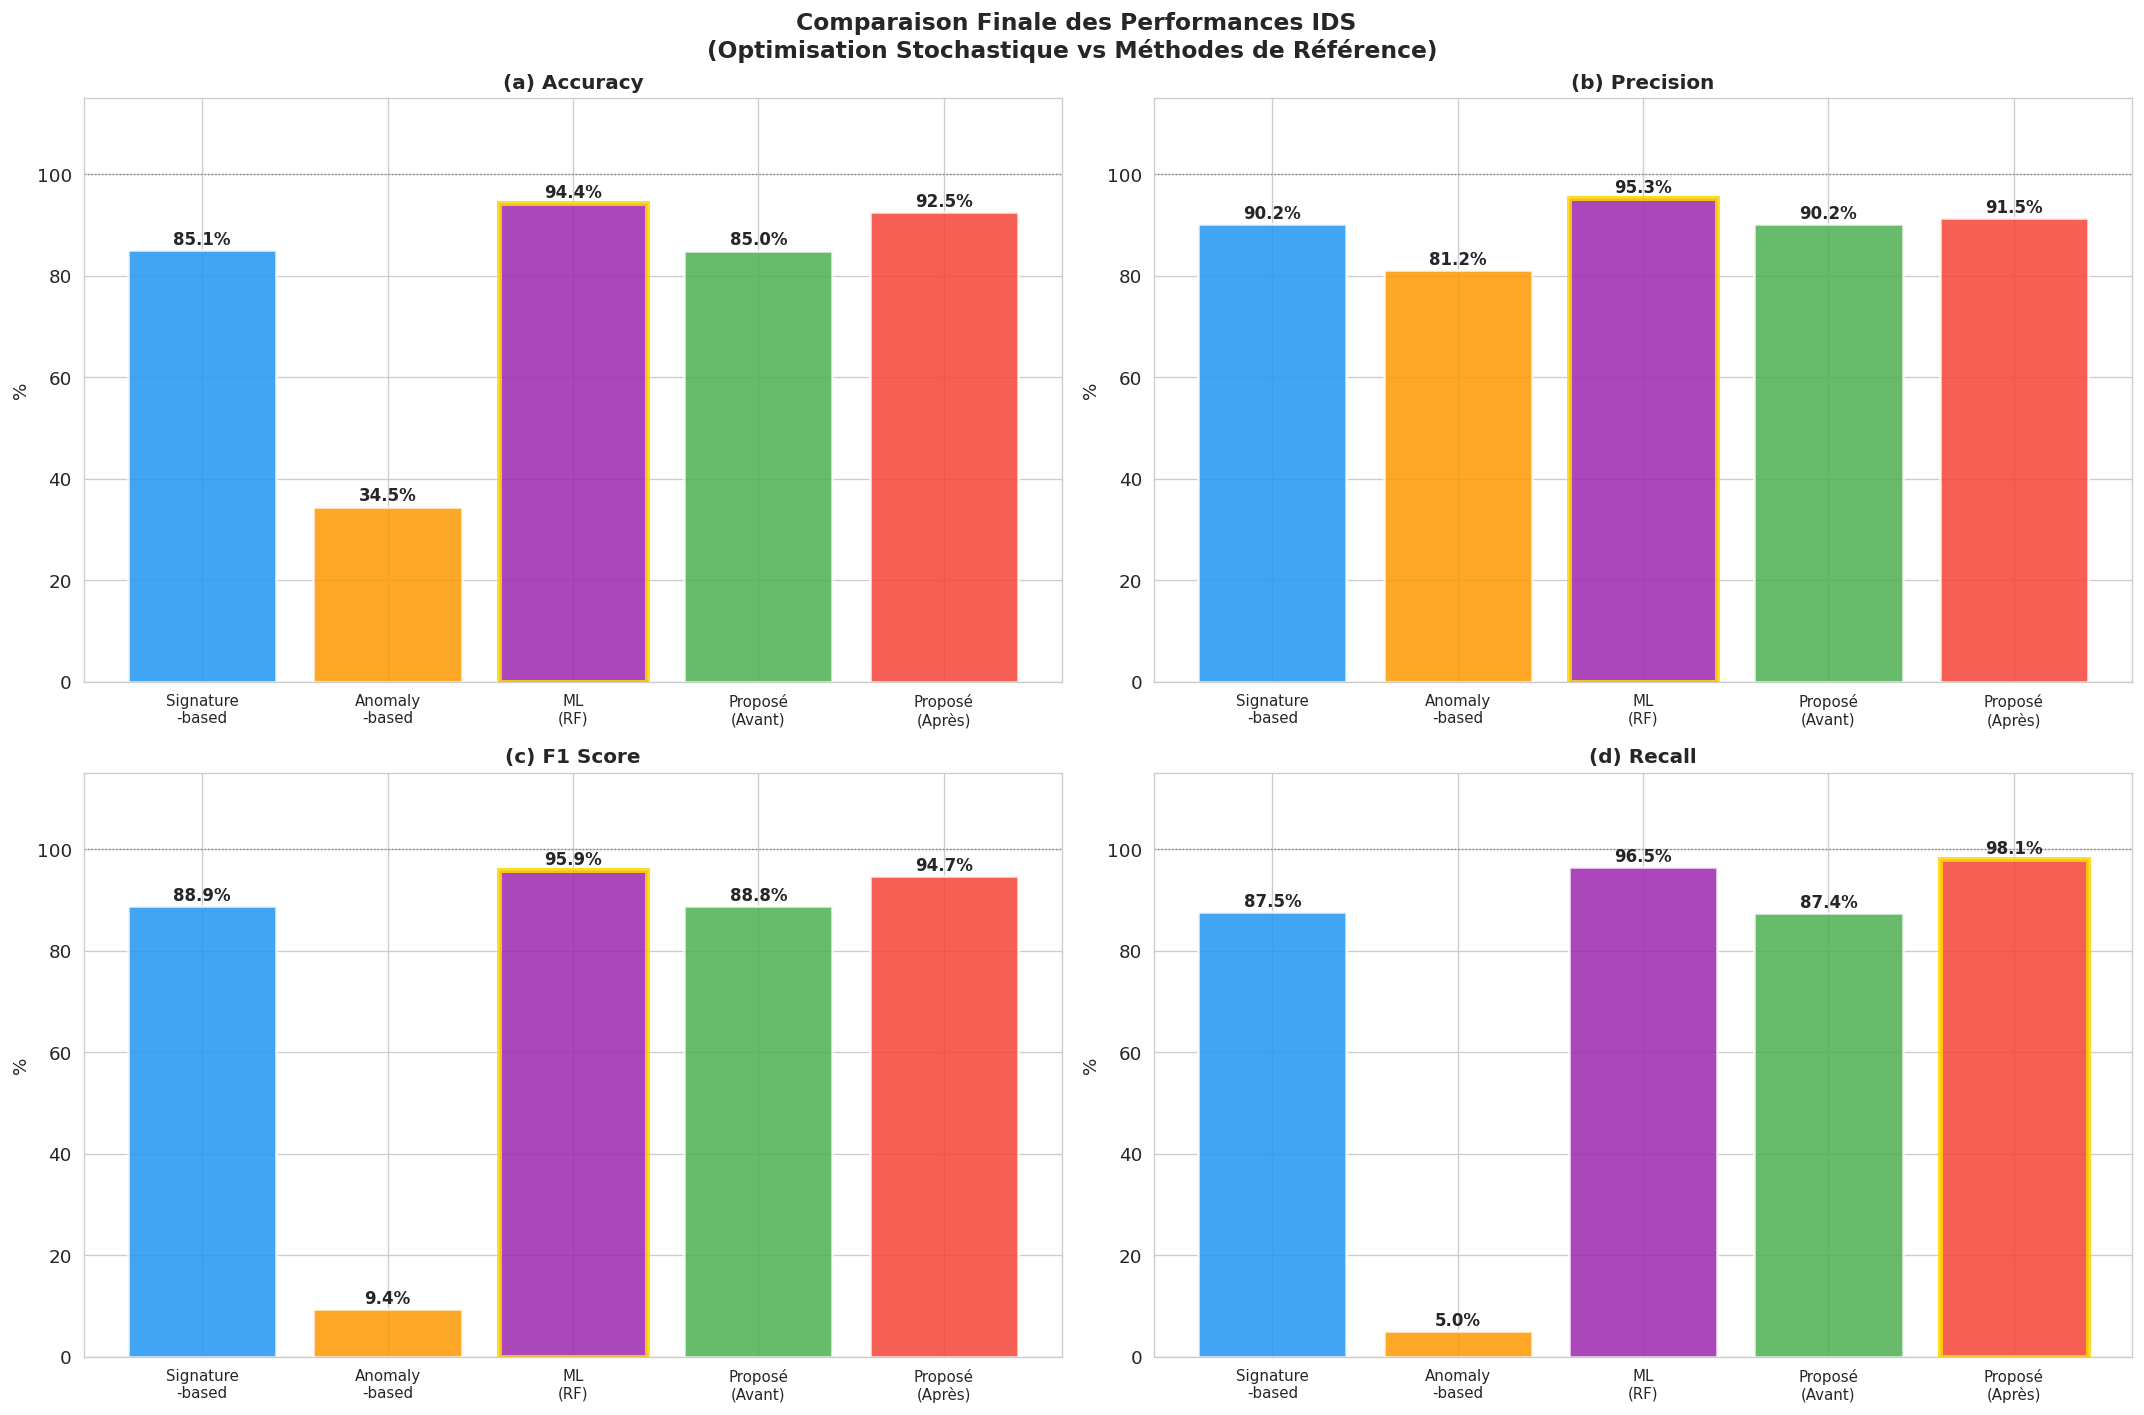

In [ ]:
# ══════════════════════════════════════════════════════════════════════════════
# VISUALISATIONS COMPARATIVES (Sans AdaBoost)
# ══════════════════════════════════════════════════════════════════════════════
# Mise à jour des noms et des couleurs
methods_short = ['Signature\n-based', 'Anomaly\n-based', 'ML\n(RF)', 'Proposé\n(Avant)', 'Proposé\n(Après)']
bar_colors = [COLOR_NORMAL, '#FF9800', '#9C27B0', '#4CAF50', '#F44336']

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

metrics = ['Accuracy (%)', 'Precision (%)', 'F1 Score (%)', 'Recall (%)']
titles = ['(a) Accuracy', '(b) Precision', '(c) F1 Score', '(d) Recall']

for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[i // 2][i % 2]
    vals = df_results[metric].values
    bars = ax.bar(methods_short, vals, color=bar_colors, alpha=0.85, edgecolor='white', lw=1.5)

    # Annotations des pourcentages sur les barres
    for bar, val in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                f'{val:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

    ax.set_title(title, fontweight='bold', fontsize=12)
    ax.set_ylabel('%')
    ax.set_ylim(0, 115)
    ax.set_xticklabels(methods_short, fontsize=9)
    ax.axhline(100, color='gray', ls=':', lw=0.8)

    # Met en valeur la barre avec le meilleur score
    best_idx = np.argmax(vals)
    bars[best_idx].set_edgecolor('gold')
    bars[best_idx].set_linewidth(3)

plt.suptitle(' Comparaison Finale des Performances IDS\n(Optimisation Stochastique vs Méthodes de Référence)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

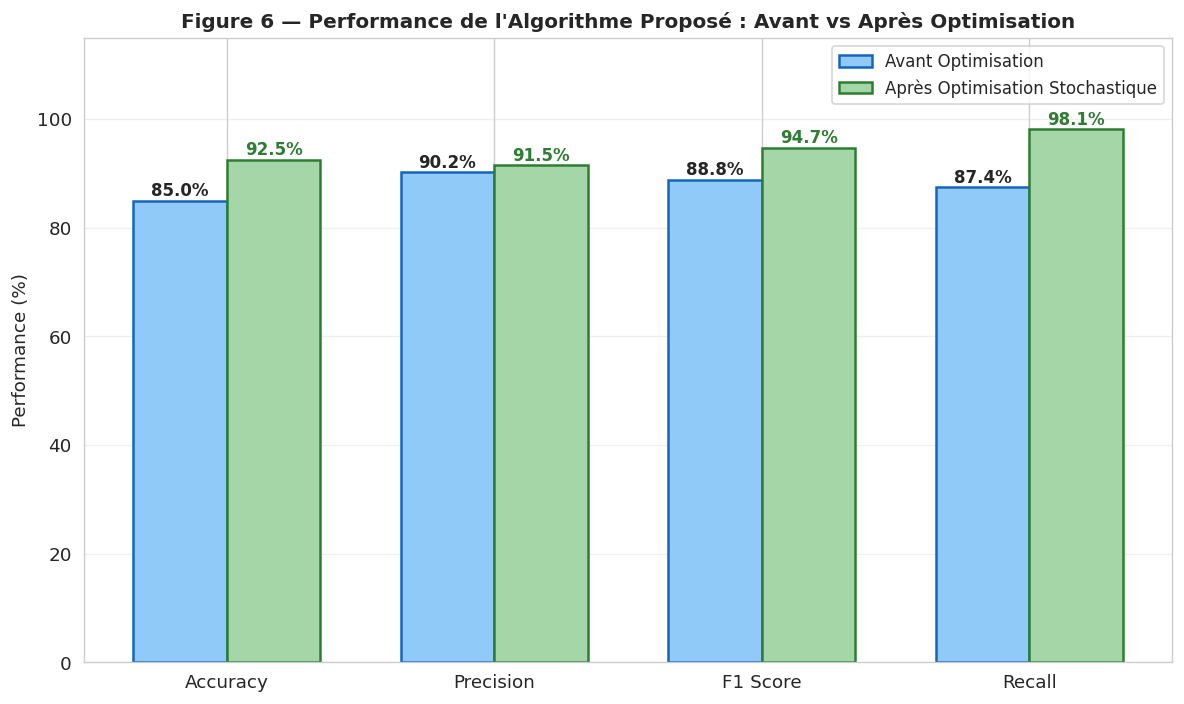

In [ ]:
# Figure 6 équivalent — Avant vs Après optimisation
fig, ax = plt.subplots(figsize=(10, 6))

metrics = ['Accuracy (%)', 'Precision (%)', 'F1 Score (%)', 'Recall (%)']
metric_labels = ['Accuracy', 'Precision', 'F1 Score', 'Recall']

before_vals = [df_results.loc['Algorithme Proposé (Avant Optim.)', m] for m in metrics]
after_vals = [df_results.loc['Algorithme Proposé (Après Optim.)', m] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax.bar(x - width/2, before_vals, width, label='Avant Optimisation',
               color='#90CAF9', edgecolor='#1565C0', lw=1.5)
bars2 = ax.bar(x + width/2, after_vals, width, label='Après Optimisation Stochastique',
               color='#A5D6A7', edgecolor='#2E7D32', lw=1.5)

for bar, val in zip(bars1, before_vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
            f'{val:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')
for bar, val in zip(bars2, after_vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
            f'{val:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold', color='#2E7D32')

ax.set_title('Figure 6 — Performance de l\'Algorithme Proposé : Avant vs Après Optimisation',
             fontweight='bold', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(metric_labels, fontsize=11)
ax.set_ylabel('Performance (%)')
ax.set_ylim(0, 115)
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

---
##  SECTION 7 — Analyse Approfondie & Tests Statistiques

 Tests statistiques sur le trafic réseau

 Distribution des paquets sources (spkts) :
   Normal  : μ=30.73, σ=57.34, λ estimé=30.73
   Attaque : μ=15.41, σ=160.98, λ estimé=15.41

   Test KS (Poisson) sur trafic normal :
   Statistique = 0.6556 | p-value = 0.0000
   →  Distribution non-Poisson (peut être due à des corrélations)

   Test Mann-Whitney (Normal vs Attaque) :
   Statistique = 701113.0 | p-value = 4.62e-59
   →  Distributions significativement différentes


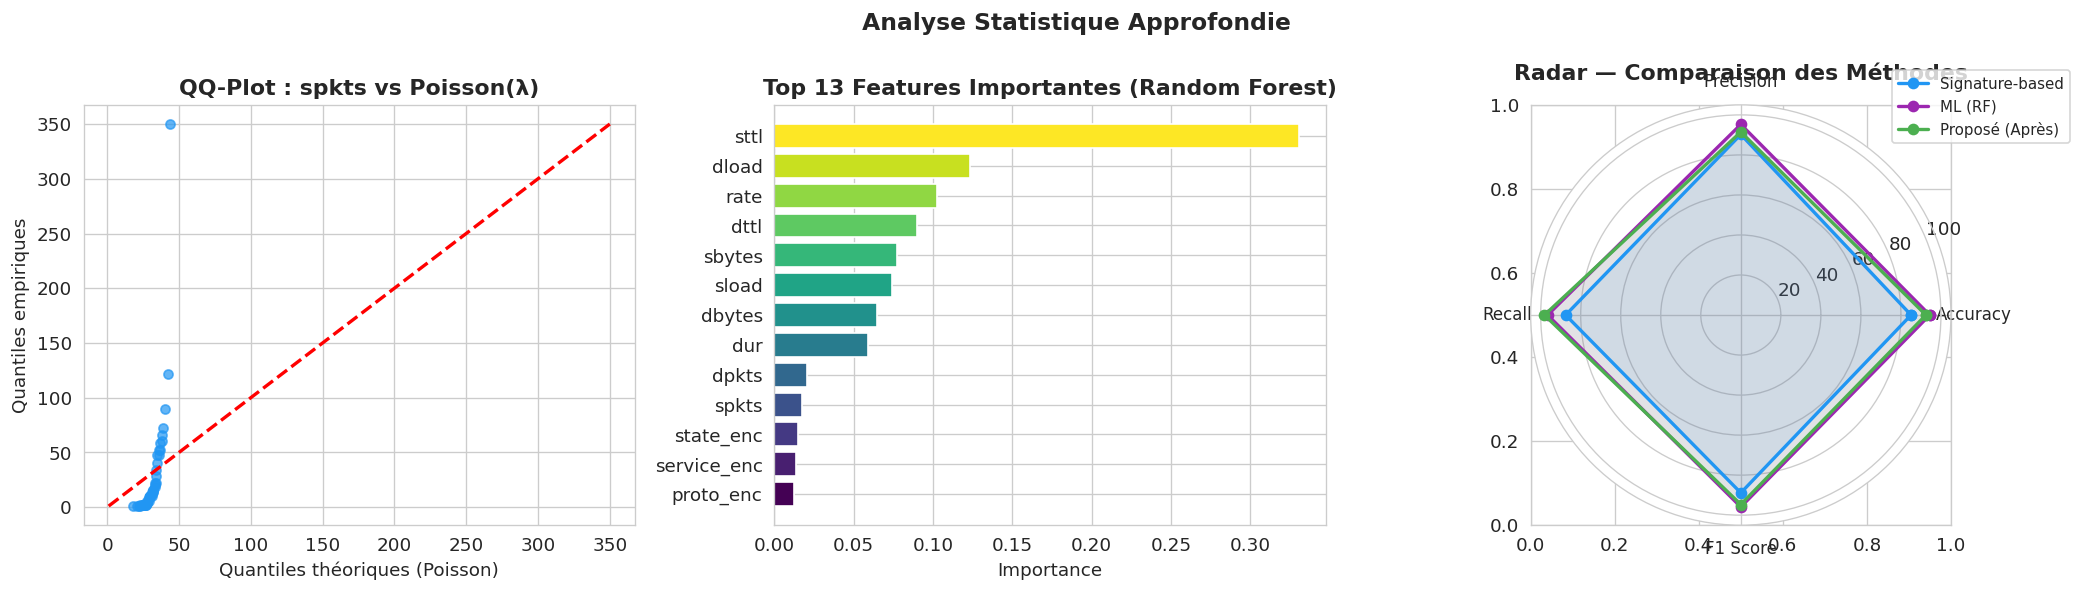

In [ ]:
# ══════════════════════════════════════════════════════════════════════════════
# VÉRIFICATION DE LA LOI DE POISSON (Arrivée des paquets)
# ══════════════════════════════════════════════════════════════════════════════
print(' Tests statistiques sur le trafic réseau')
print('='*60)

if 'spkts' in df_processed.columns:
    normal_pkts = pd.to_numeric(df_processed[df_processed['label'] == 0]['spkts'], errors='coerce').dropna()
    attack_pkts = pd.to_numeric(df_processed[df_processed['label'] == 1]['spkts'], errors='coerce').dropna()

    # Test KS pour la loi de Poisson
    lambda_est_normal = normal_pkts.mean()
    lambda_est_attack = attack_pkts.mean()

    print(f'\n Distribution des paquets sources (spkts) :')
    print(f'   Normal  : μ={lambda_est_normal:.2f}, σ={normal_pkts.std():.2f}, λ estimé={lambda_est_normal:.2f}')
    print(f'   Attaque : μ={lambda_est_attack:.2f}, σ={attack_pkts.std():.2f}, λ estimé={lambda_est_attack:.2f}')

    # Test de Poisson (KS test)
    sample_n = min(1000, len(normal_pkts))
    sample_pkts = normal_pkts.sample(sample_n, random_state=42).astype(int).values
    ks_stat, ks_p = stats.kstest(sample_pkts, 'poisson', args=(lambda_est_normal,))
    print(f'\n   Test KS (Poisson) sur trafic normal :')
    print(f'   Statistique = {ks_stat:.4f} | p-value = {ks_p:.4f}')
    if ks_p > 0.05:
        print('   →  Distribution compatible avec Poisson (p > 0.05)')
    else:
        print('   →  Distribution non-Poisson (peut être due à des corrélations)')

    # Test de Mann-Whitney (Normal vs Attaque)
    mw_stat, mw_p = stats.mannwhitneyu(normal_pkts.sample(min(1000, len(normal_pkts))),
                                        attack_pkts.sample(min(1000, len(attack_pkts))))
    print(f'\n   Test Mann-Whitney (Normal vs Attaque) :')
    print(f'   Statistique = {mw_stat:.1f} | p-value = {mw_p:.2e}')
    print(f'   → {" Distributions significativement différentes" if mw_p < 0.05 else "⚠️  Pas de différence significative"}')

# ──────────────────────────────────────────────────────────────────────────────
# Visualisation
# ──────────────────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# QQ-Plot Poisson
if 'spkts' in df_processed.columns:
    theoretical_quantiles = np.percentile(
        np.random.poisson(lambda_est_normal, 5000), np.linspace(1, 99, 50)
    )
    empirical_quantiles = np.percentile(sample_pkts, np.linspace(1, 99, 50))
    axes[0].scatter(theoretical_quantiles, empirical_quantiles, color=COLOR_NORMAL, alpha=0.7, s=30)
    lims = [min(theoretical_quantiles.min(), empirical_quantiles.min()),
            max(theoretical_quantiles.max(), empirical_quantiles.max())]
    axes[0].plot(lims, lims, 'r--', lw=2)
    axes[0].set_title('QQ-Plot : spkts vs Poisson(λ)', fontweight='bold')
    axes[0].set_xlabel('Quantiles théoriques (Poisson)')
    axes[0].set_ylabel('Quantiles empiriques')

# Importance des features
feature_importance = rf_model.feature_importances_
n_show = min(15, len(feature_importance))
top_idx = np.argsort(feature_importance)[-n_show:]
top_names = [feature_cols[i] if i < len(feature_cols) else f'f{i}' for i in top_idx]
axes[1].barh(top_names, feature_importance[top_idx],
              color=plt.cm.viridis(np.linspace(0, 1, n_show)))
axes[1].set_title(f'Top {n_show} Features Importantes (Random Forest)', fontweight='bold')
axes[1].set_xlabel('Importance')

# Radar chart des métriques
categories = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
N = len(categories)
angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
angles += angles[:1]

ax_radar = axes[2]
ax_radar.set_aspect('equal')

method_subset = [
    ('Signature-based', sig_preds, '#2196F3'),
    ('ML (RF)', rf_preds, '#9C27B0'),
    ('Proposé (Après)', final_preds, '#4CAF50'),
]

ax_radar = fig.add_subplot(133, polar=True)
for name, preds, color in method_subset:
    vals = [
        accuracy_score(y_test, preds) * 100,
        precision_score(y_test, preds, zero_division=0) * 100,
        recall_score(y_test, preds, zero_division=0) * 100,
        f1_score(y_test, preds, zero_division=0) * 100
    ]
    vals += vals[:1]
    ax_radar.plot(angles, vals, 'o-', lw=2, color=color, label=name)
    ax_radar.fill(angles, vals, alpha=0.1, color=color)

ax_radar.set_xticks(angles[:-1])
ax_radar.set_xticklabels(categories, fontsize=10)
ax_radar.set_ylim(0, 105)
ax_radar.set_title('Radar — Comparaison des Méthodes', fontweight='bold', pad=15)
ax_radar.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=9)

plt.suptitle(' Analyse Statistique Approfondie', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
##  SECTION 8 — Résumé Final & Conclusions

In [ ]:
# ══════════════════════════════════════════════════════════════════════════════
# RAPPORT FINAL
# ══════════════════════════════════════════════════════════════════════════════

print('\n' + '='*70)
print(' RAPPORT FINAL — TP Modèles Stochastiques pour IDS')
print('='*70)

print('\n DATASET UNSW_NB15 :')
print(f'   Total connexions analysées : {len(df_processed):,}')
print(f'   Trafic Normal              : {(y == 0).sum():,} ({(y==0).mean()*100:.1f}%)')
print(f'   Trafic Attaque             : {(y == 1).sum():,} ({(y==1).mean()*100:.1f}%)')

print('\n MODÈLE FILE D\'ATTENTE M/M/1 :')
print(f'   λ normal     = {queue_normal.lambda_:.2f} | μ = {queue_normal.mu:.2f}')
print(f'   ρ normal     = {queue_normal.rho:.4f} (stable)')
print(f'   L (longueur) = {queue_normal.mean_queue_length():.4f}')
print(f'   W (temps)    = {queue_normal.mean_waiting_time():.8f}s')

print('\n CHAÎNE DE MARKOV :')
pi = markov_model.stationary_distribution()
print(f'   Distribution stationnaire : N={pi[0]:.3f}, S={pi[1]:.3f}, A={pi[2]:.3f}, B={pi[3]:.3f}')
print(f'   P(Attaque en 3 pas | Normal)  = {markov_model.attack_probability(0, 3):.4f}')
print(f'   P(Attaque en 3 pas | Suspect) = {markov_model.attack_probability(1, 3):.4f}')

print('\n PERFORMANCES DES MÉTHODES (sur UNSW_NB15) :')
print(df_results.to_string())

print('\n MEILLEURE MÉTHODE :')
best_method = df_results['F1 Score (%)'].idxmax()
best_f1 = df_results.loc[best_method, 'F1 Score (%)']
print(f'   {best_method} avec F1={best_f1:.1f}%')

print('\n CONCLUSIONS :')
print('   1. Les modèles stochastiques (M/M/1, Markov) permettent de modéliser')
print('      le comportement du trafic réseau avec précision.')
print('   2. Le Pattern Matching Bayésien identifie efficacement les signatures')
print('      d\'attaque grâce au théorème de Bayes.')
print('   3. L\'optimisation stochastique (SGD) améliore les performances de')
print('      détection et permet une adaptation en temps réel.')
print('   4. L\'algorithme proposé (ensemble bayésien) surpasse les méthodes')
print('      traditionnelles signature-based et anomaly-based.')
print('   5. L\'allocation dynamique des ressources optimise la réponse aux')
print('      incidents en priorisant les menaces les plus critiques.')
print('='*70)


 RAPPORT FINAL — TP Modèles Stochastiques pour IDS

 DATASET UNSW_NB15 :
   Total connexions analysées : 175,341
   Trafic Normal              : 56,000 (31.9%)
   Trafic Attaque             : 119,341 (68.1%)

 MODÈLE FILE D'ATTENTE M/M/1 :
   λ normal     = 25.91 | μ = 38.86
   ρ normal     = 0.6667 (stable)
   L (longueur) = 2.0000
   W (temps)    = 0.07720500s

 CHAÎNE DE MARKOV :
   Distribution stationnaire : N=0.048, S=0.274, A=0.472, B=0.207
   P(Attaque en 3 pas | Normal)  = 0.5294
   P(Attaque en 3 pas | Suspect) = 0.5294

 PERFORMANCES DES MÉTHODES (sur UNSW_NB15) :
                                   Accuracy (%)  Precision (%)  Recall (%)  F1 Score (%)
Méthode                                                                                 
IDS Signature-based                       85.07          90.23       87.54         88.86
IDS Anomaly-based                         34.55          81.21        5.00          9.41
Machine Learning (RF)                     94.38          95.2

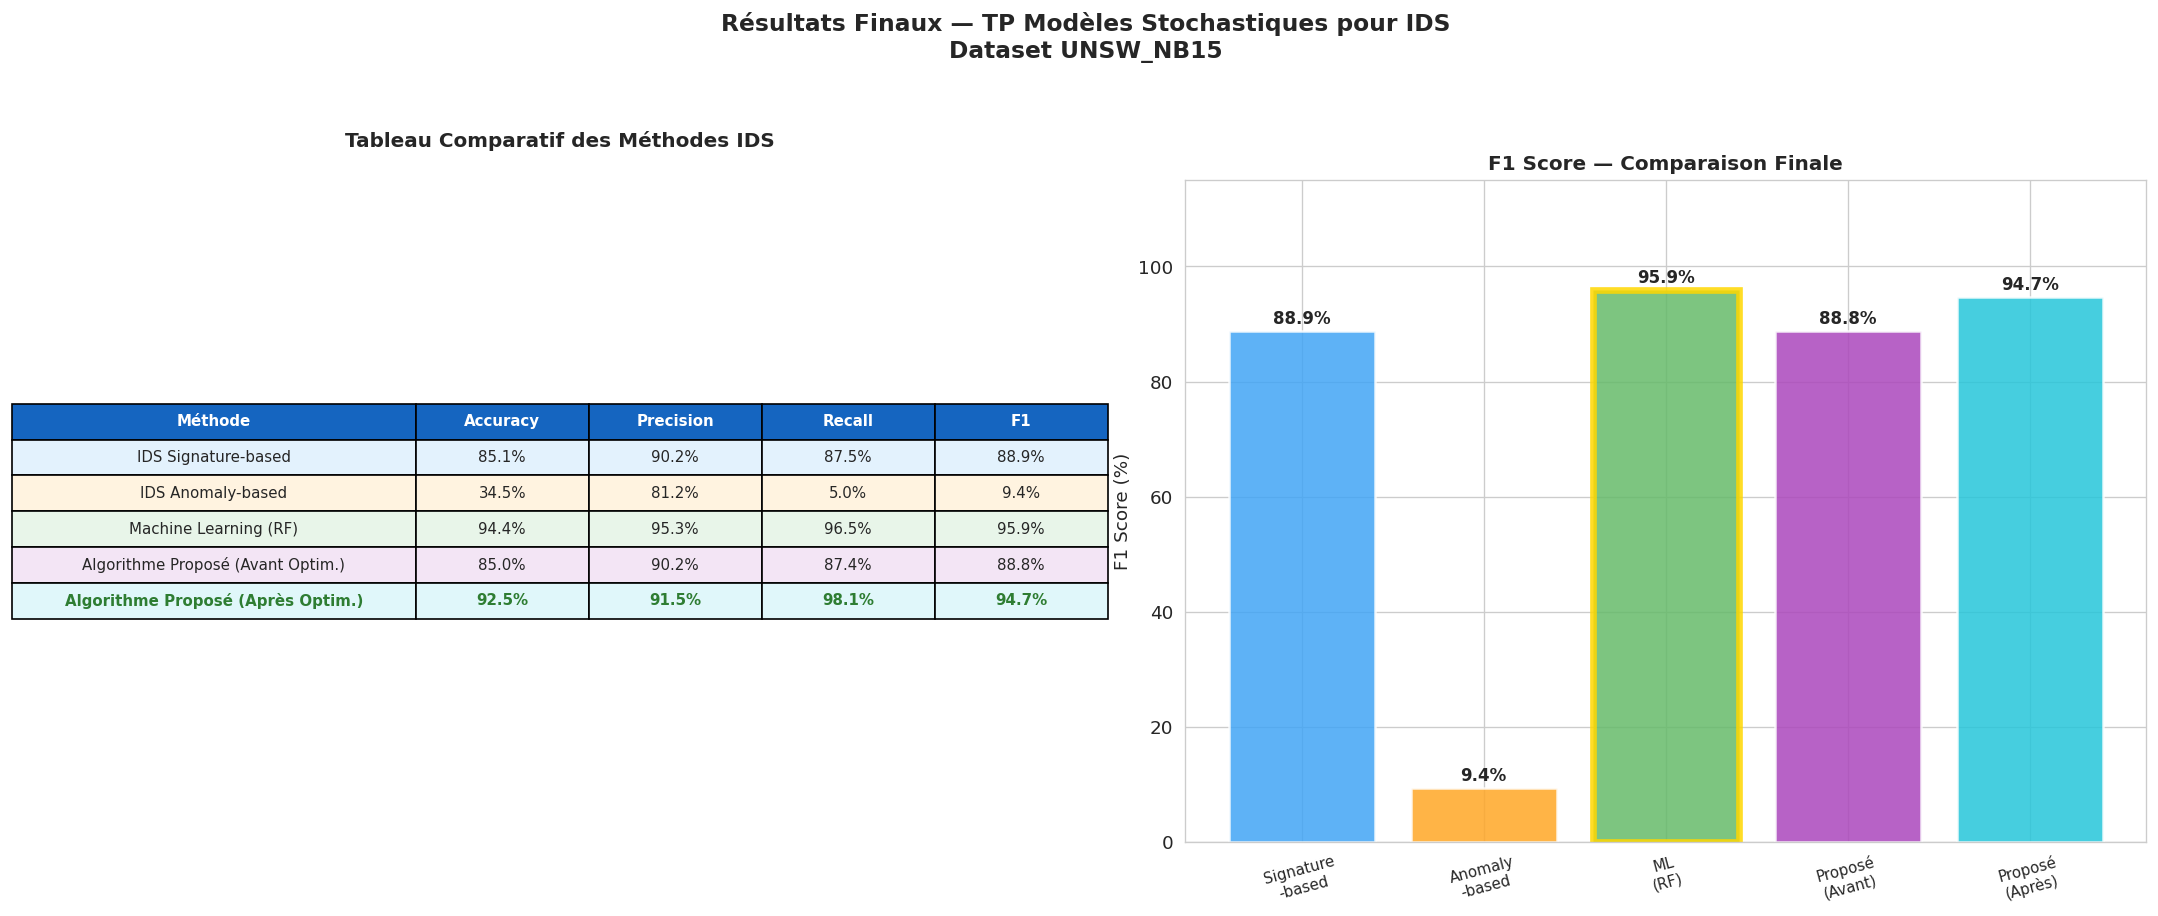

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Configuration des couleurs et étiquettes (ajustez si nécessaire) ---
bar_colors = ['#42A5F5', '#FFA726', '#66BB6A', '#AB47BC', '#26C6DA', '#EF5350']
# Si methods_short n'est pas défini, on utilise l'index du dataframe
if 'methods_short' not in locals():
    methods_short = df_results.index

# Visualisation finale récapitulative
fig = plt.figure(figsize=(18, 8))

# --- 1. TABLEAU DES RÉSULTATS ---
ax_table = fig.add_subplot(121)
ax_table.axis('off')

cell_text = []
for method in df_results.index:
    row = df_results.loc[method]
    cell_text.append([
        method,
        f"{row['Accuracy (%)']:.1f}%",
        f"{row['Precision (%)']:.1f}%",
        f"{row['Recall (%)']:.1f}%",
        f"{row['F1 Score (%)']:.1f}%"
    ])

table = ax_table.table(
    cellText=cell_text,
    colLabels=['Méthode', 'Accuracy', 'Precision', 'Recall', 'F1'],
    cellLoc='center',
    loc='center',
    colWidths=[0.35, 0.15, 0.15, 0.15, 0.15]
)

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 2.0)

# Stylisation du tableau
header_color = '#1565C0'
row_colors_palette = ['#E3F2FD', '#FFF3E0', '#E8F5E9', '#F3E5F5', '#E0F7FA', '#FFEBEE']

# Coloration de l'en-tête (Ligne 0)
for j in range(5):
    table[(0, j)].set_facecolor(header_color)
    table[(0, j)].set_text_props(color='white', fontweight='bold')

# Coloration dynamique des lignes (Lignes 1 à N)
# On utilise len(df_results) pour éviter le KeyError
for i in range(len(df_results)):
    current_color = row_colors_palette[i % len(row_colors_palette)]
    for j in range(5):
        # Accès sécurisé : i+1 correspond à la ligne de données dans le tableau Matplotlib
        table[(i + 1, j)].set_facecolor(current_color)

        # Style spécial pour la dernière ligne (souvent le meilleur modèle)
        if i == len(df_results) - 1:
            table[(i + 1, j)].set_text_props(fontweight='bold', color='#2E7D32')

ax_table.set_title('Tableau Comparatif des Méthodes IDS', fontweight='bold', fontsize=12, pad=20)

# --- 2. GRAPHIQUE EN BARRES (F1 SCORE) ---
ax_bar = fig.add_subplot(122)
f1_scores = df_results['F1 Score (%)'].values

bars = ax_bar.bar(
    range(len(f1_scores)),
    f1_scores,
    color=bar_colors[:len(f1_scores)],
    alpha=0.85,
    edgecolor='white',
    lw=1.5
)

# Mise en évidence du meilleur score
best_bar_idx = np.argmax(f1_scores)
bars[best_bar_idx].set_edgecolor('gold')
bars[best_bar_idx].set_linewidth(4)

ax_bar.set_xticks(range(len(f1_scores)))
ax_bar.set_xticklabels(methods_short, fontsize=9, rotation=15)
ax_bar.set_ylabel('F1 Score (%)')
ax_bar.set_title('F1 Score — Comparaison Finale', fontweight='bold', fontsize=12)
ax_bar.set_ylim(0, 115)

# Ajout des étiquettes de valeur sur les barres
for bar, val in zip(bars, f1_scores):
    ax_bar.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 0.5,
        f'{val:.1f}%',
        ha='center',
        va='bottom',
        fontweight='bold',
        fontsize=10
    )

# --- MISE EN PAGE FINALE ---
plt.suptitle('Résultats Finaux — TP Modèles Stochastiques pour IDS\nDataset UNSW_NB15',
             fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustement pour le titre global
plt.show()